# VAE Using Extended Kalman Filter for Speech Recognition using TIMIT  

The purpose of this demo is to help you learn about variational autoencoder. The algorithm is being implemented is from the paper "Auto-Encoding Variational Bayes", by Diederik P Kingma, Max Welling (https://arxiv.org/abs/1312.6114).

Followed the logic:
VAE: https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py 

TIMIT: https://github.com/jackjhliu/Pytorch-End-to-End-ASR-on-TIMIT

EKF: https://github.com/jnez71/kalmaNN

We are using TIMIT data.

You are free to change model acrhitecture, or any part of the logic. 

If you have any suggestions or find errors, please, don't be hesitate to text me at jayanta.jayantamukherjee@gmail.com

In [1]:
import argparse
import data
import eval_utils
import logging, sys
import matplotlib.pyplot as plt
import os
from prepare_data import prepare_csv
from show_history import plotLearning
import time 
import timeit
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torchvision
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')

from torchvision import transforms
import torch.optim as optim
import yaml

/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Prepare Data from Raw WAV files: TIMIT


In [2]:
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

prepare_csv("../TIMIT/TIMIT_DATA/")

TRAIN.csv is created.
DEV.csv is created.
TEST.csv is created.
Data preparation is complete !


#### Load Config & Clean up Previous Run Stats

In [3]:
cfgFile = "config/default.yaml" 
import shutil

with open(cfgFile) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
        
if not cfg['logdir']:
    save_path = os.path.splitext(cfgFile)[0]
    
if os.path.exists(save_path):
    shutil.rmtree(save_path)

os.mkdir(save_path)

### Set the constants

In [4]:
gpu_id = 0
workers = 0
ckpt_freq = 10

## Conv VAE

In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

DIM = 64 # Model dimensionality
OUTPUT_DIM = 40*9 # Number of pixels in Spectrum

## Convolutional Variational Autoencoder

class Encoder(nn.Module):
    def __init__(self,  Z_DIM, log_var_=None, dropout=0.2, relu=0.1, n_filters=40):
        super(Encoder, self).__init__()
        '''
        kernel_size = (height, width)
        stride = (heigh, width)
        Conv1: filters = 64, filter size = 1 * F, stride = (1,1), tanh(), BatchNorm
        Cov2: filters = 128, filter size = 3 * 1, stride = (2,1), tanh(), BatchNorm
        Cov3: filters = 256, filter size = 3 * 1, stride = (2,1), tanh(), BatchNorm
        Fc1: Units = 512, tanh, BatchNorm
        Gauss: Units = 128
        
        1*(19*40) --> 64*(19*1) --> 128*(9*1) --> 256*(4*1) --> (512) --> (128)
        '''
        if relu == 0:
            activation = nn.Tanh()
        else:
            activation = nn.LeakyReLU(relu)

        self.F = n_filters

        self.Conv_1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(1,self.F), stride=1, padding=0, bias=False),
            nn.Dropout2d(dropout),
            nn.BatchNorm2d(64),
            activation
        )
        self.Conv_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3,1), stride=(2,1), padding=0, bias=False),
            nn.Dropout2d(dropout),
            nn.BatchNorm2d(128),
            activation
        )
        self.Conv_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(3,1), stride=(2,1), padding=0, bias=False),
            nn.Dropout2d(dropout),
            nn.BatchNorm2d(256),
            activation
        )

        self.Fc1 =nn.Sequential(
            nn.Linear(1024, 512, bias=False),
            nn.Dropout2d(dropout),
            nn.BatchNorm1d(512),
            activation
        )

        self.mu = nn.Linear(512, Z_DIM, bias=False)
        self.fix = log_var_
        if log_var_ != None:
            self.log_var = log_var_
        else:
            self.log_var = nn.Linear(512, Z_DIM, bias=False)

    def forward(self, input):
        output = input.view(-1, 1, 19, self.F)
        out = self.Conv_1(output)
        out = self.Conv_2(out)
        out = self.Conv_3(out)
        out = out.view(-1, 1024)
        out = self.Fc1(out)
        mu = self.mu(out)
        if self.fix == None:
            log_var = self.log_var(out)
        else:
            log_var = Variable(2*torch.log(self.log_var * torch.ones(mu.size())))
        if torch.cuda.is_available():
            log_var = log_var.cuda()
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, Z_DIM, dropout=0.2, relu=0.1, n_filters = 40):
        super(Decoder, self).__init__()
        '''
        Gauss: Units = 48
        Fc1: Units = 512, tanh, BatchNorm
        Cov3: filters = 256, filter size = 3 * 1, stride = (2,1), tanh(), BatchNorm
        Cov2: filters = 128, filter size = 3 * 1, stride = (2,1), tanh(), BatchNorm
        Conv1: filters = 64, filter size = 1 * F, stride = (1,1), tanh(), BatchNorm
        1*(128*1) --> 1*(512*1) --> 256*(4*1) --> 128*(9*1) --> 64*(19*1) --> 1*(19*40)
        '''
        if relu == 0:
            activation = nn.Tanh()
        else:
            activation = nn.LeakyReLU(relu)


        self.F = n_filters

        self.Gauss = nn.Linear(Z_DIM, 512, bias=False)

        self.Fc1 = nn.Sequential(
            nn.Linear(512, 1024, bias=False),
            nn.Dropout2d(dropout),
            nn.BatchNorm1d(1024),
            activation
        )
        #self.deconv3 = nn.ConvTranspose2d(4*DIM, 2*DIM, kernel_size=(3,1),stride=(2,1))

        self.Conv_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=(3,1), stride=(2,1), bias=False),
            nn.Dropout2d(dropout),
            nn.BatchNorm2d(128),
            activation
        )

        self.Conv_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3,1), stride=(2,1), bias=False),
            nn.Dropout2d(dropout),
            nn.BatchNorm2d(64),
            activation
        )


        self.Conv_1 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=(1,self.F), stride=1, bias=False),
            nn.Dropout2d(dropout),
            nn.BatchNorm2d(1),
            activation
        )

    def forward(self, input):
        output = self.Gauss(input)
        output = self.Fc1(output)
        output = output.view(-1, 256, 4, 1)
        output = self.Conv_3(output)
        output = self.Conv_2(output)
        output = self.Conv_1(output)
        output = output.view(-1, 19*self.F)
        return output

class ConvVAE(nn.Module):
    def __init__(self, Z_DIM, log_var_=None, dropout=0.2, relu=0.1, n_filters=40):
        super(ConvVAE, self).__init__()

        '''
        VAE:
        Input --> Encoder --> mu,log_var --> Decoder --> Output
        1 * (9*40) -->  Encoder --> 1 * 48 --> Decoder --> 1 * (9*40) 
        '''
        self.encoder = Encoder(Z_DIM, log_var_, dropout=dropout, relu=relu, n_filters=n_filters)
        self.decoder = Decoder(Z_DIM, dropout=dropout, relu=relu, n_filters=n_filters)

    def forward(self, input):
        mu, log_var = self.encoder(input)
        # reparam
        z = self.reparameterize(mu.float(), log_var.float())
        output = self.decoder(z)
        return output, mu, log_var

    def reparameterize(self, mu, log_var):
        if self.training:
            std = log_var.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            if torch.cuda.is_available():
                eps = eps.cuda()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def sample(self, z):
        return self.decoder(z)


### Define Learning Parameters

In [6]:
# leanring parameters
epochs = 10
batch_size = 64
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Initialize Linear VAE Model

In [8]:
gpu_id = 0
workers = 0
ckpt_freq = 10

#input_dim = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = cfg['train']['batch_size']
#transform = transforms.Compose([transforms.ToTensor()])

# Create dataset
train_loader = data.load(split='train', batch_size=batch_size, workers = workers)
dev_loader = data.load(split='dev', batch_size=batch_size)
hidden_size = hidden_size=cfg['model']['hidden_size']
activation=cfg['model']['activation']

# Build model
tokenizer = torch.load('tokenizer.pth')
print("tokenizer.vocab length = ", len(tokenizer.vocab))
#      self, target_size, hidden_size, encoder_layers, decoder_layers, drop_p=0.
#self, Z_DIM, log_var_=None, dropout=0.2, relu=0.1, n_filters=40
model = ConvVAE(Z_DIM=len(tokenizer.vocab),
                log_var_=None,
                dropout=cfg['model']['drop_p'],
                relu=0.1,
                n_filters=10)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

TRAIN set size: 3696
DEV set size: 1152
tokenizer.vocab length =  66


### Define Final Loss Method

In [9]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Define Training Method

In [10]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
        (xs, xlens, ys) = data
        
        print("inside fit::: xs shape = ", xs.shape, ", xlens shape = ", xlens.shape, ", ys shape = ", ys.shape)
        #data, _ = data
        #data = data.to(device)
        #data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(xs)
        print("xs shape = ", xs.shape)
        print("xlens shape = ", xlens.shape)
        print("ys shape = ", ys.shape, ", reconstruction shape = ", reconstruction.shape) 
        #ys1 = ys.reshape(reconstruction.shape)
        #reconstruction = reconstruction.reshape(ys.shape)
        #criterion = nn.CrossEntropyLoss()
        bce_loss = criterion(reconstruction, ys)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

### Define Validation Method

In [11]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataloader.dataset)/dataloader.batch_size)):
            (xs, xlens, ys) = data
            print("inside validate::: xs shape = ", xs.shape, ", xlens shape = ", xlens.shape, ", ys shape = ", ys.shape)
            #data, _ = data
            #data = data.to(device)
            #data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(xs)
            print("xs shape = ", xs.shape)
            print("xlens shape = ", xlens.shape)
            print("ys shape = ", ys.shape, ", reconstruction shape = ", reconstruction.shape)
            print("ys = ", ys)

            print("reconstruction = ", reconstruction)
            #criterion = nn.CrossEntropyLoss()
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:8]))
                save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

### Train & Eval

In [12]:
epochs = 10
train_loss = []
val_loss = []
RMS = []
train_epoch_durations = []
eval_epoch_durations = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    start_train_epoch = time.time()
    train_epoch_loss = fit(model, train_loader)
    end_train_epoch = time.time()
    train_epoch_duration = end_train_epoch - start_train_epoch
    train_epoch_durations.append(train_epoch_duration)

    val_epoch_loss = validate(model, val_loader)
    end_eval_epoch = time.time()
    eval_epoch_duration = end_eval_epoch - end_train_epoch
    eval_epoch_durations.append(eval_epoch_duration) 
    
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 10


  0%|          | 0/57 [00:00<?, ?it/s]/home/jay/.conda/envs/jay/lib/python3.6/site-packages/torchaudio/compliance/kaldi.py:574: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  fft = torch.rfft(strided_input, 1, normalized=False, onesided=True)
  0%|          | 0/57 [00:00<?, ?it/s]

inside fit::: xs shape =  torch.Size([64, 170, 240]) , xlens shape =  torch.Size([64]) , ys shape =  torch.Size([64, 70])


RuntimeError: shape '[-1, 1, 19, 10]' is invalid for input of size 2611200

#### Plot History

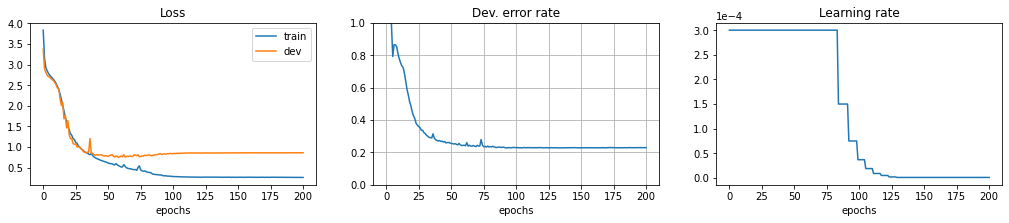

<Figure size 432x288 with 0 Axes>

In [12]:
plotLearning("config/default/history.csv")

In [13]:
from torch.autograd import Variable
import torch.utils.data

batch_size = cfg['train']['batch_size']
input_dim = 28 * 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for step, (xs, xlens, ys) in enumerate(train_loader):
    xs = xs.to(device) 
    ys = ys.to(device)
    #inputs = Variable(data.resize_(batch_size, input_dim))

modeled_data = model(xs, xlens, ys) #model(inputs)
print("modeled_data (loss) = ", modeled_data)
print("xs = ", xs)
print("ys = ", ys)
#model_data = modeled_data[0].reshape(batch_size, input_dim)
#print(input_data)        
#plt.imshow(model_data[0].detach().numpy().reshape(28, 28), cmap='gray')
#plt.show(block=True)

modeled_data (loss) =  tensor(0.1368, device='cuda:0', grad_fn=<NllLossBackward>)
xs =  tensor([[[-15.9424, -15.9424, -15.9424,  ..., -11.8372, -11.9033, -11.7925],
         [-15.9424, -15.9424, -15.9424,  ..., -10.6204, -11.5617, -11.4858],
         [-15.9424, -15.9424, -15.9424,  ..., -11.3104, -11.5202, -11.3478],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[-15.9424, -15.9424, -15.9424,  ..., -11.0079, -11.4618, -10.7826],
         [-15.9424, -15.9424, -15.9424,  ..., -12.4406, -11.7202, -11.2884],
         [-15.9424, -15.9424, -15.9424,  ..., -10.9167, -10.7133, -11.4138],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0

### Eval

In [14]:
# Restore checkpoint
info = torch.load("config/default/best.pth")
split = 'test'
print ("Dev. error rate of checkpoint: %.4f @epoch: %d" % (info['dev_error'], info['epoch']))
    
# Build model
tokenizer = torch.load('tokenizer.pth')
model = KalmanVAE(input_size=cfg['model']['input_size'],
            target_size=len(tokenizer.vocab),
            hidden_size=cfg['model']['hidden_size'],
            encoder_layers=cfg['model']['encoder_layers'],
            decoder_layers=cfg['model']['decoder_layers'],
            activation=cfg['model']['activation'],
            drop_p=cfg['model']['drop_p'])
 
model.load_state_dict(info['weights'])
model.eval() 
model.cuda()

# Evaluate
error = eval_utils.get_error(train_loader, model)
print ("Error rate on %s set = %.4f" % (split, error))

Dev. error rate of checkpoint: 0.2273 @epoch: 92
Calculating error rate ... (#batch: 58/58)
Error rate on test set = 0.0665


### Plot Training & Eval time

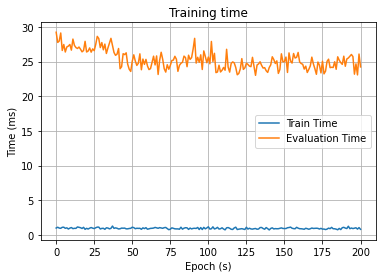

In [15]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = train_epoch_durations
#calculate the values for the Gaussian curve
x = np.arange(len(train_epoch_durations))
#plot the Gaussian curve
ax.plot(x, y, label = "Train Time")

ax.set(xlabel='Epoch (s)', ylabel='Time (ms)',
       title='Training time')

xe = np.arange(len(eval_epoch_durations))
ye = eval_epoch_durations
#plot sine wave
ax.plot(xe, ye, label = "Evaluation Time")

ax.grid()

#show the legend
plt.legend()
plt.show()

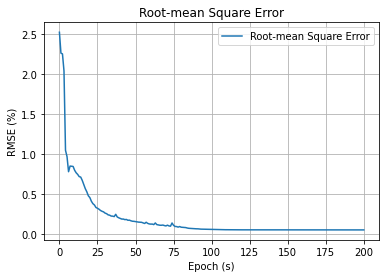

<Figure size 432x288 with 0 Axes>

In [16]:
# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()

#now create y values for the second plot
y = RMS
#calculate the values for the Gaussian curve
x = np.arange(len(RMS))
#plot the Gaussian curve
ax.plot(x, y, label = "Root-mean Square Error")

ax.set(xlabel='Epoch (s)', ylabel='RMSE (%)',
       title='Root-mean Square Error')

ax.grid()

#show the legend
plt.legend()
plt.show()
plt.savefig('img/rmse-ekf.pdf')
plt.savefig('img/rmse-ekf.png')

#### Inference auxiliary method

In [17]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import argparse
from matplotlib.pyplot import figure


def showAttention(predictions, attentions):
    output_words = predictions.split()
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,15))
    #figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    ax.set_yticklabels([''] + output_words)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

### Inference

Predict:
jh ao r dcl jh ix z pcl p eh r ix nx oy dx ix bcl b aw dx ax f y ux tcl ch axr gcl g ae s sh ao r dx ix dcl jh h#
Ground-truth:
h# jh ao r dcl jh ix z pcl p eh r ix nx oy dx ax bcl b aw dx ax f y ux tcl ch axr gcl g ae s sh ao r dx ix dcl jh h#



/home/jay/.conda/envs/jay/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


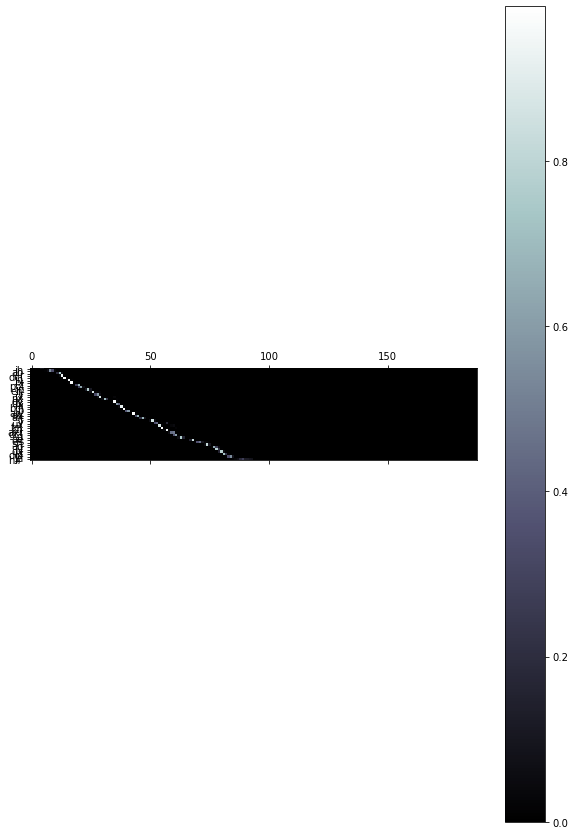

Predict:
b r ay tcl s ah n sh ay n sh ih m er z ao n dh iy y ow sh en h#
Ground-truth:
h# b r ay tcl s ah n sh ay n sh ih m er z ao n dh iy y ow sh en h#



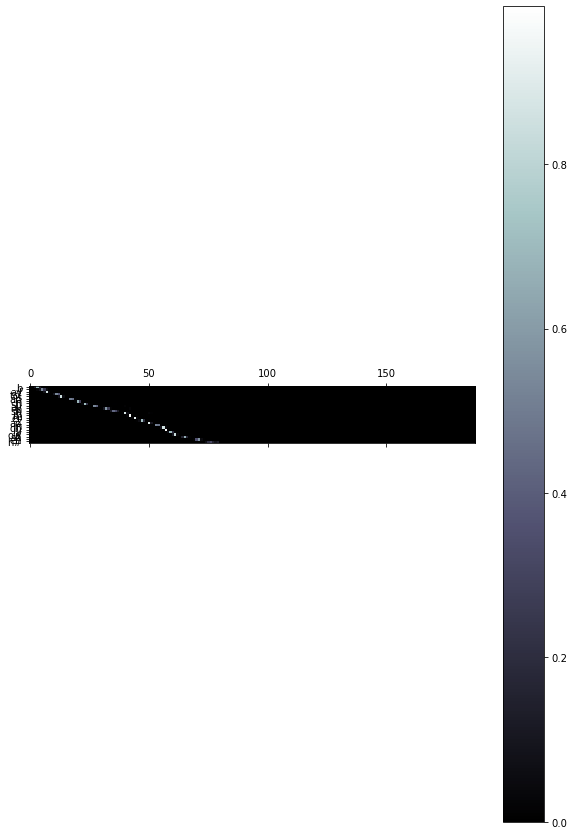

Predict:
l ae n dcl b ey s tcl t r ey dx aa r w uh dcl d hv ae l pcl p w ax dh ih s tcl t ae s kcl k h#
Ground-truth:
h# l ae n dcl b ey s tcl t r ey dx aa r w uh dcl ix hv eh l pcl p w ax dh ih s tcl t ae s kcl k h#



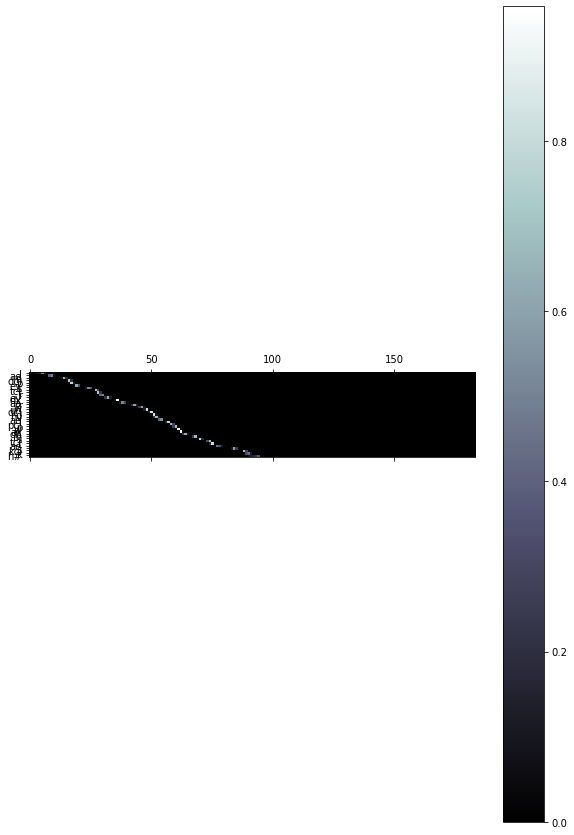

Predict:
w iy eh v n ah dh ih ng d eh hv ay dx ah n d axr ix bcl b uh sh el h#
Ground-truth:
h# w iy eh v n ah dh ih ng d ix hv ay dx ah n d er ax bcl b uh sh el h#



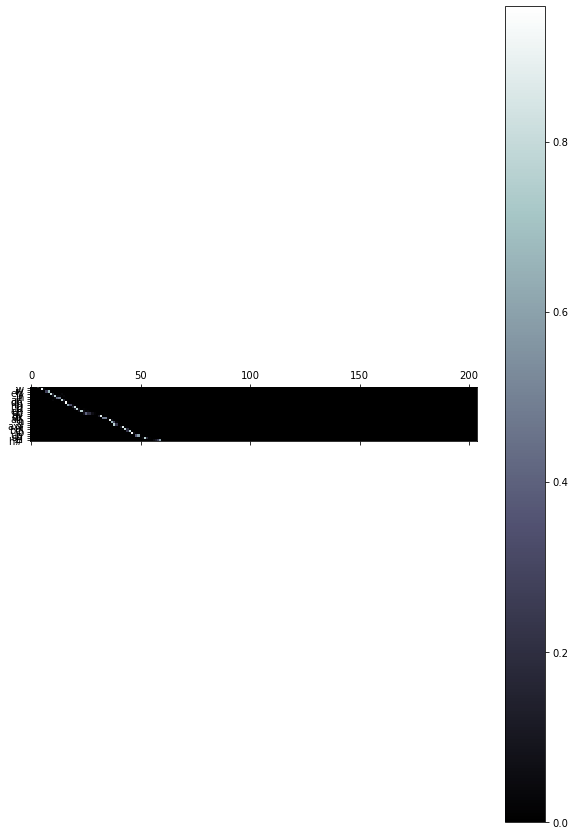

Predict:
ao l dh eh tcl t ay m r ay f el v eh r el z axr pcl p oy nx ih n ao n w ey v axr ix ng l ae dx ih z hh eh dx ix n bcl b aa dx iy h#
Ground-truth:
h# q ao l dh eh tcl t ay m r ay f el v eh r ax l z axr pcl p oy nx ih n ah n w ey v axr ix ng l ih eh dx ih z hh eh dx ix n bcl b aa dx ix h#



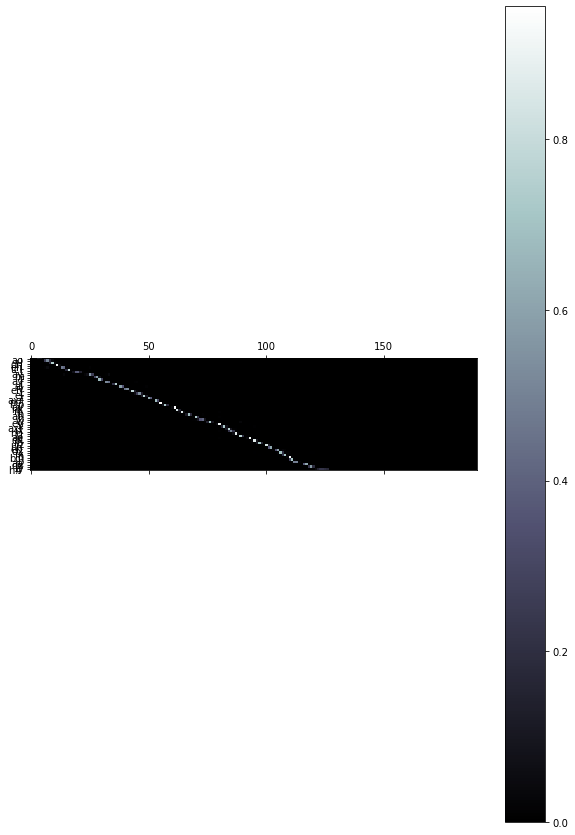

Predict:
q aa m ax n dcl z ix m pcl p ix s tcl t ae sh ah n ah tcl s epi aa r n aa tcl s ow hv ay ix n q oy l bcl b ax dx aa r ix tcl ch en pcl p r ow tcl t iy n h#
Ground-truth:
h# q aa m ax n dcl d z ix m pcl p ix s tcl t ae sh ow n ah tcl t s epi aa r n aa tcl t s ow hv ay ix n q oy l bcl b uh dx aa r ix tcl ch en pcl p r ow tcl t iy n h#



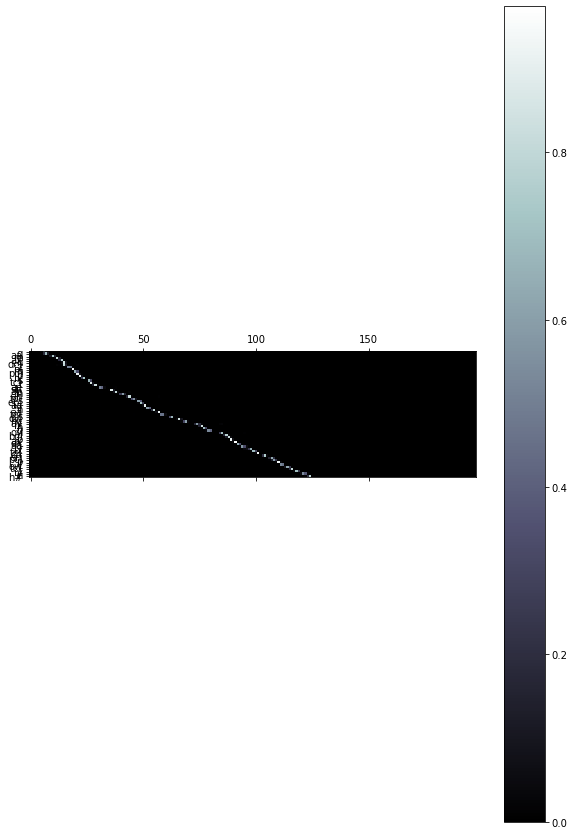

Predict:
f er m ow m ih n tcl pau b oy q ae n m aw n tcl hh ah ng ix n m ih dcl d eh r h#
Ground-truth:
h# f er m ow m ih n tcl pau b oy q ae n m aw n tcl hh ah ng ih n m ih dcl d eh r h#



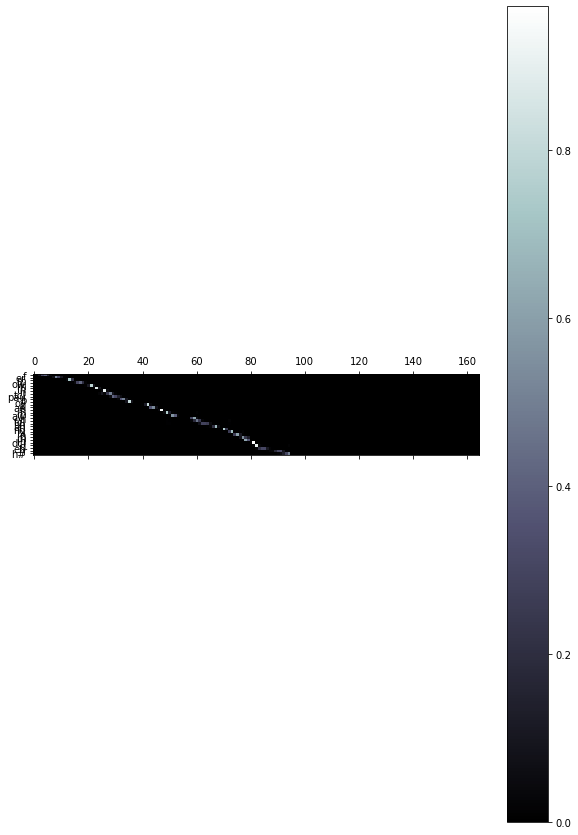

Predict:
dh ey y ux z dcl d ix nx ix gcl g r eh s ix v pcl p l iy s epi m ax n tcl t ix f l ae gcl th aa q l ix s epi m ow dx axr ix s tcl s h#
Ground-truth:
h# dh ey y ux z dcl d ix nx ix gcl g r eh s ix v pcl p l iy s epi m ax n tcl t ax f l ae gcl th aa q l ih s epi m ow dx axr ix s tcl s h#



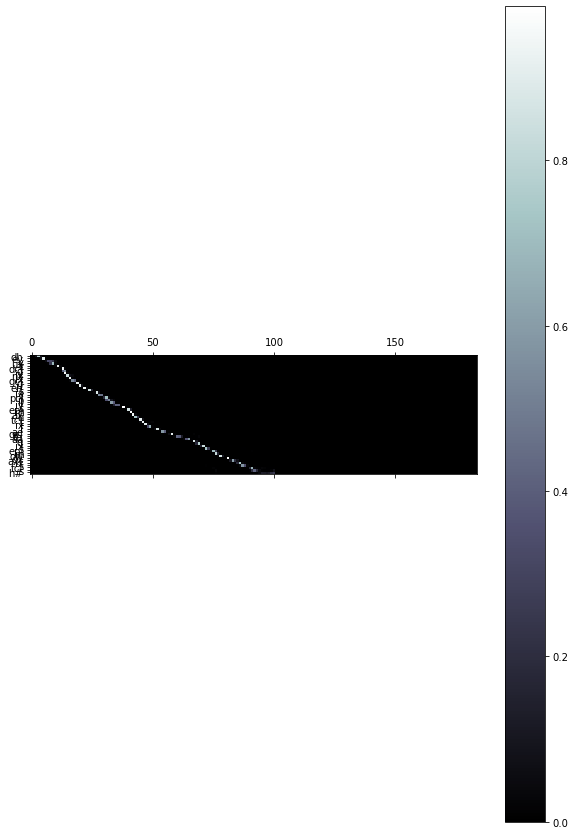

Predict:
b aa aa l ax dcl jh ix s y ux z r ey dx iy ow ae kcl t ix v q ay s ix tcl t ow pcl p s ix s tcl t ah dx iy m ay kcl k r ow ao r gcl g en ix z ax m z h#
Ground-truth:
h# b ay ao l ah dcl jh ix s y ux z r ey dx iy ow ae kcl t ix v q ay s ix tcl t ow pcl p s ix s tcl t ah dx ix m ay kcl k r ow ao r gcl g en ix z ax m z h#



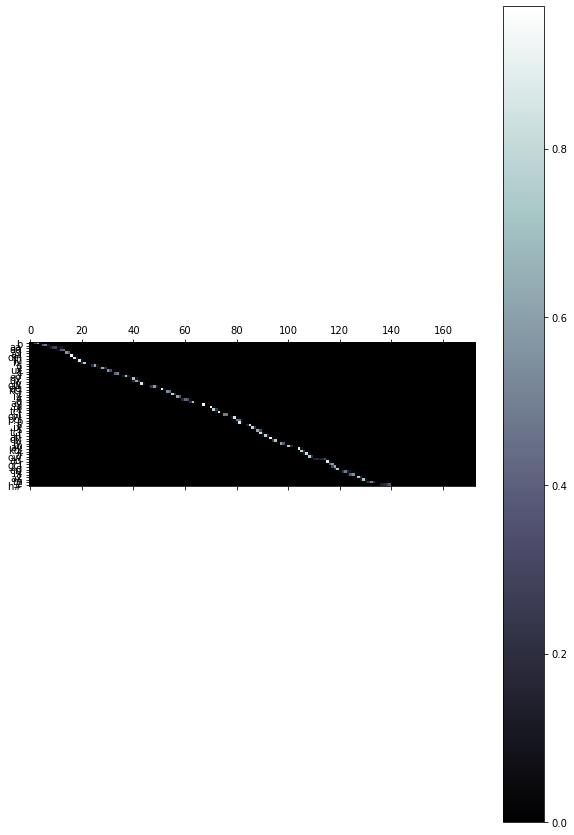

Predict:
q ay dcl jh ah s ao dcl jh ih m n ih r dh iy n ux q aa r kcl k iy l aa dcl jh ax-h kcl k el m ux z iy ax m h#
Ground-truth:
h# q aa dcl jh ih s ao dcl jh ih m n ih r dh iy n ux q aa r kcl k iy el l aa dcl jh ax-h kcl k el m ux z iy ah m h#



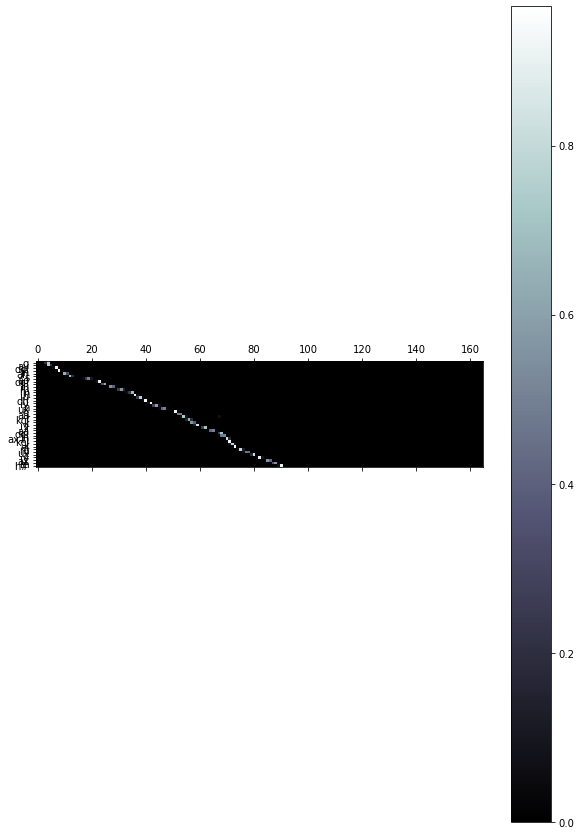

Predict:
p er s en ow pcl p r iy dcl d ih s pcl p ix z ih sh ix n s tcl t eh n dcl t ix bcl b l ah n tcl dh ix q ey ah pau q eh n ih n tcl t er n ax v oy s q ix z epi w eh l h#
Ground-truth:
h# p er s en el pcl p r iy dcl d ih s pcl p ix z ih sh ix n s tcl t eh n dcl t ix bcl b l ah n tcl dh ix q ey ah pau q eh n ih n tcl t er n ax v oy s q ix z epi w eh l h#



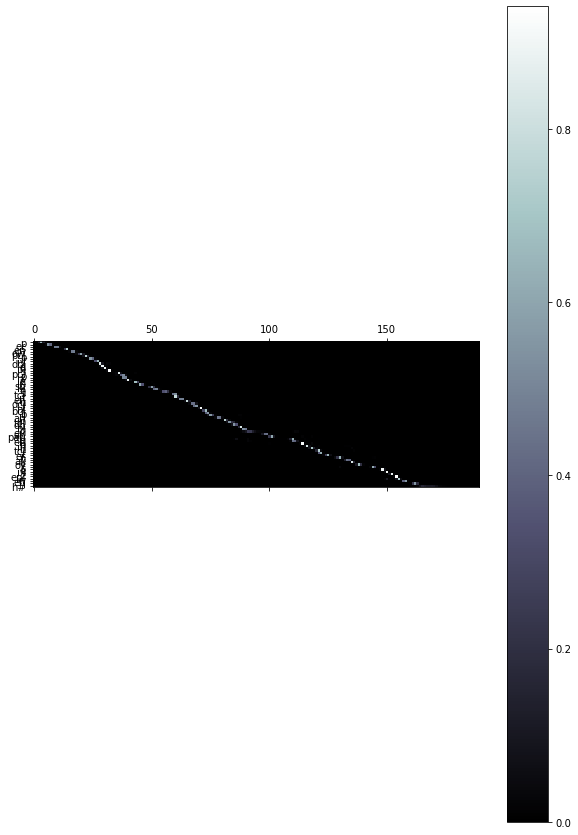

Predict:
hh ax pcl p r ow tcl ch er eh n axr v y uw w ix s tcl t ae tcl ch uw eh s kcl k em pcl p ow zh axr h#
Ground-truth:
h# hh ax pcl p r ow tcl ch axr ih n axr v y ux w ix s tcl t ae tcl ch ux eh s kcl k em pcl p ow zh axr h#



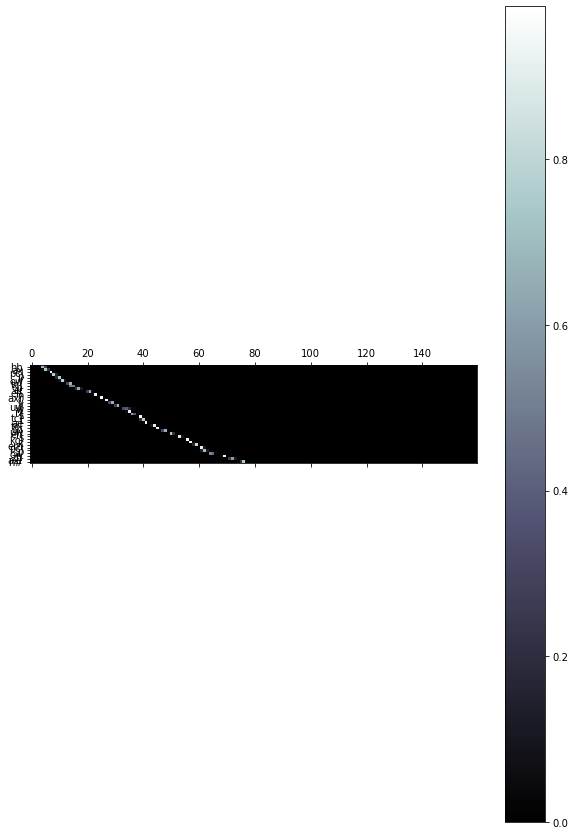

Predict:
hh iy pcl p ih kcl d ah pcl n ay n pcl p eh axr z q ax v s aa kcl k s f axr q iy tcl ch bcl b r ah dh axr h#
Ground-truth:
h# hh iy pcl p ih kcl d ah pcl n ay n pcl p eh axr z q ax v s aa kcl k s f axr q iy tcl ch bcl b r ah dh axr h#



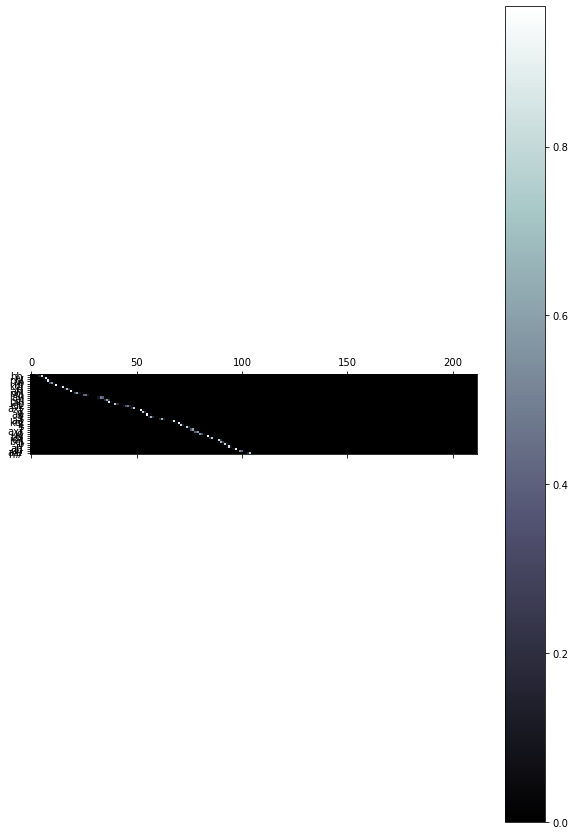

Predict:
p ih ng gcl g w ax n z l ih v n ih er dcl d ix q ay s iy pau q ae n q ao r tcl t ix kcl k h#
Ground-truth:
h# p ih ng gcl g w ax n z l ih v n ih axr dcl d ix q ay s ix pau q ae n q ao r tcl t ix kcl k h#



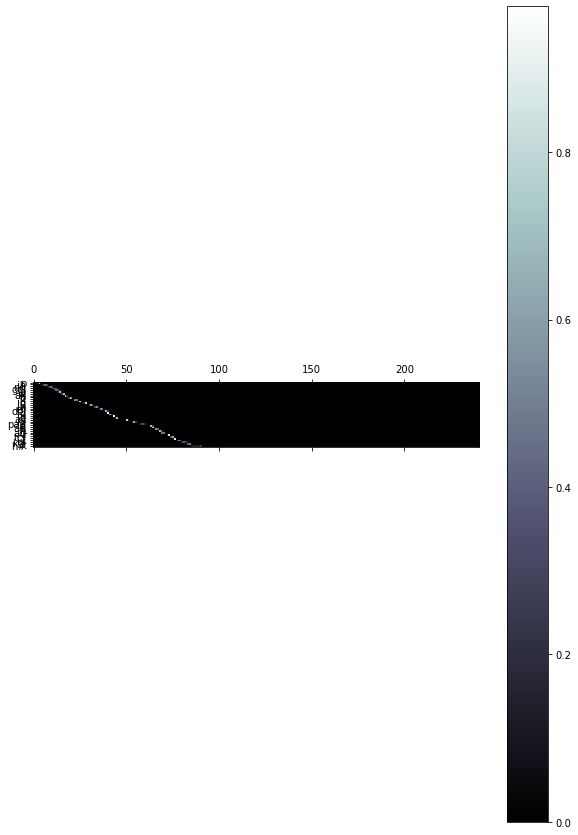

Predict:
n ow q ae n tcl s dcl jh ih n w ah z tcl t eh kcl t ax-h bcl b el ax n s er tcl en dcl d aa r kcl s f ih r kcl k el q eh r iy ah z ax m ow s eh l z h#
Ground-truth:
h# n ow q ae n t ax-h jh ih n w ah z dcl d ax-h tcl t eh kcl t ax-h bcl b el ax n s er tcl en dcl d ao r kcl s f ih er kcl k el q eh r iy ah z en m ow s eh l z h#



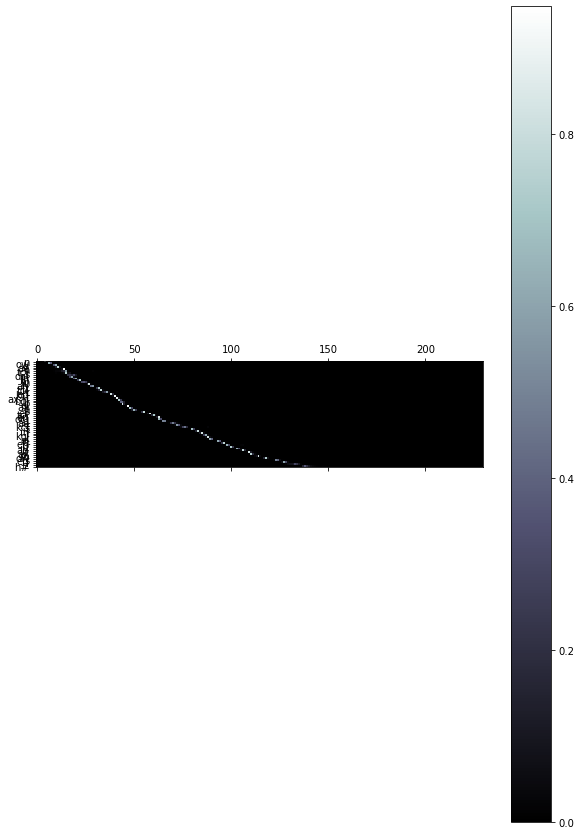

Predict:
s ow hv iy hv ay dcl z dh ix m ey ix n ey z h#
Ground-truth:
h# s ow hv iy hv ay dcl z dh ix m ey ix n ey z h#



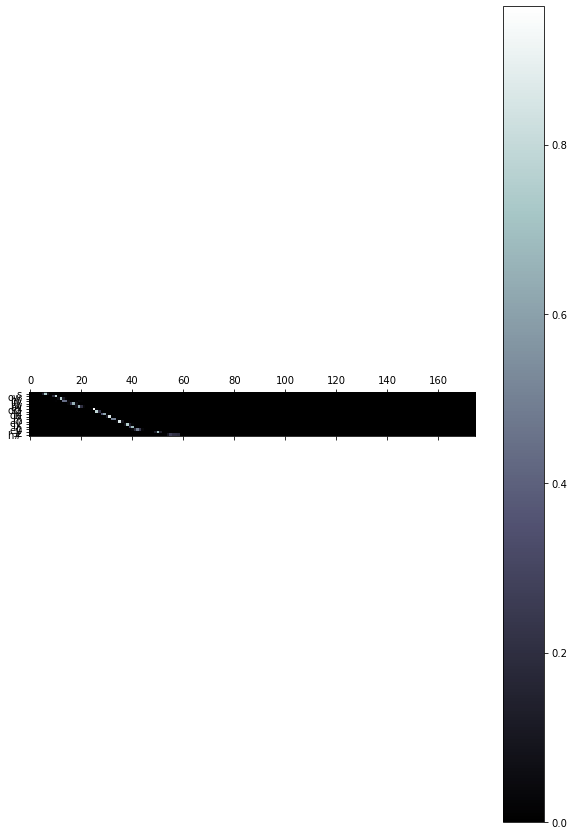

Predict:
l aa tcl s ax f ao r en m uw v iy z hh eh v s ah bcl t ay dx el s h#
Ground-truth:
h# l aa tcl t s ax f ao r en m uw v iy z hh eh v s ah bcl t ay dx el s h#



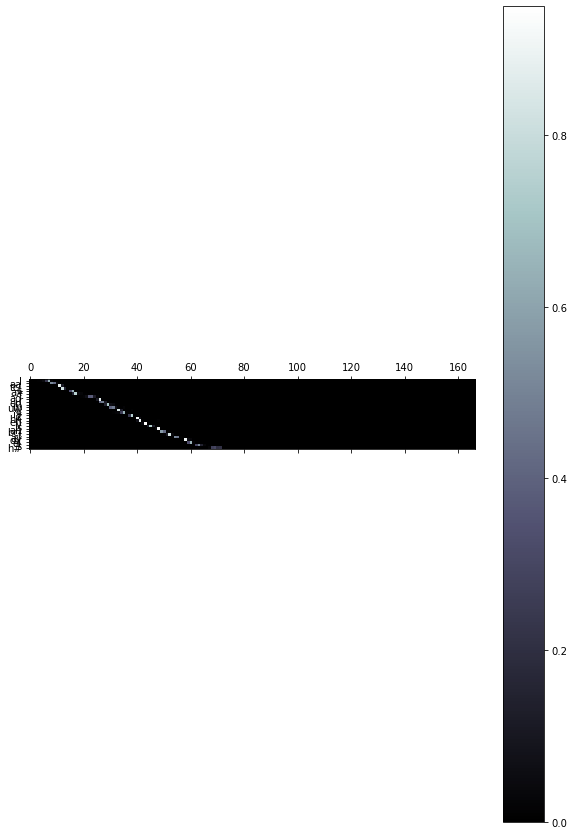

Predict:
hh ih z ay z w axr dcl d aa r kcl pau f l uw ix dcl d pau f ih r f el pau eh n iy gcl g ey v ix s ay eh z m aa n aa f w ix n ih ax n h#
Ground-truth:
h# hh ih z ay z epi w axr dcl d aa r kcl pau f l uw ix dcl d pau f ih r f el pau eh n iy gcl g ey v ix s ay eh z m aa n ay f w ix n ih ax n h#



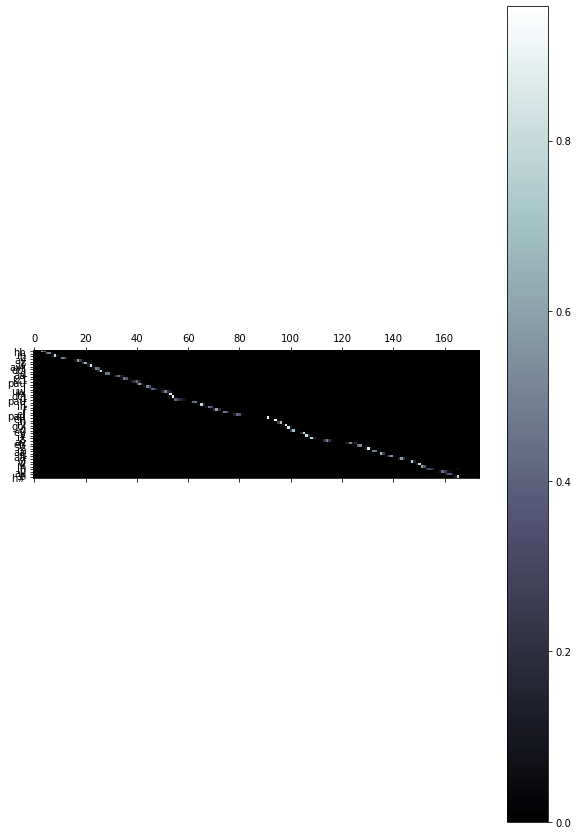

Predict:
k aa dx ih z tcl ch iy z epi w ix tcl ch ay z ix z dcl d ax l ih sh ix s h#
Ground-truth:
h# k aa dx ix jh tcl ch iy z epi w ix tcl ch ay z ix z dcl d ax l ih sh ix s h#



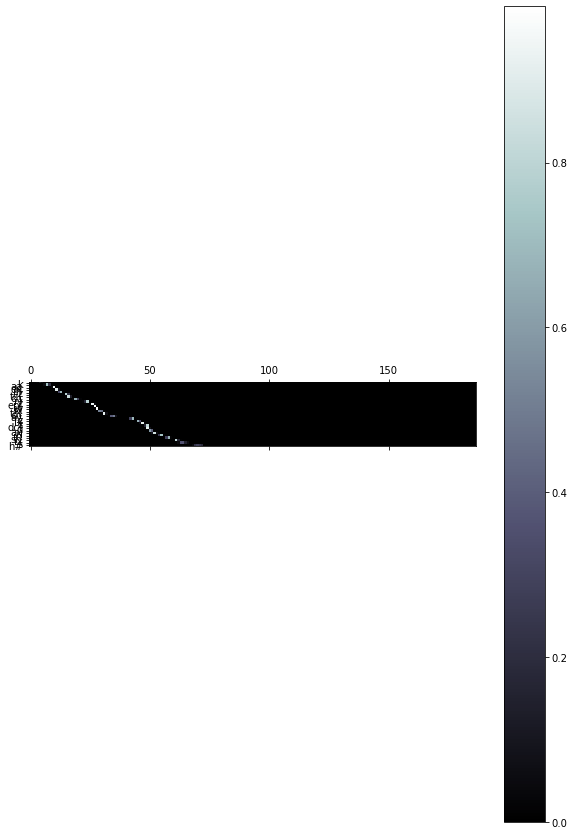

Predict:
dh ix kcl k oy y er w ah z ix dcl d ax w ao r f h#
Ground-truth:
h# dh ix kcl k ao iy er w ah z ax dcl d ax w ao r f h#



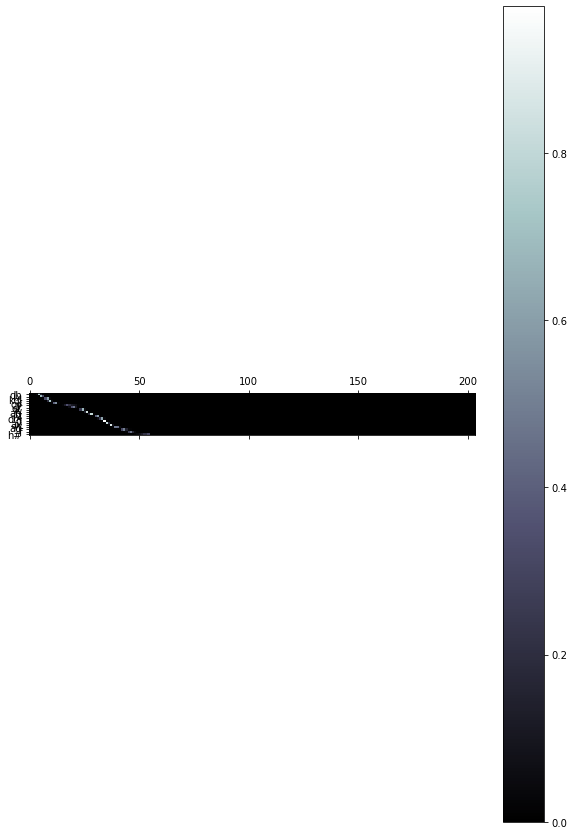

Predict:
s ay ix n tcl t ih f ix kcl p r aa gcl r eh s kcl k ah m z f r ah m dh ax pau dh ix v eh l ax pcl m ax n q ax v n ux tcl t eh kcl n iy kcl k s h#
Ground-truth:
h# s ay ih n tcl t ih f ix kcl p r aa gcl r eh s kcl k ah m z f r ah m dh ax dcl d ix v eh l ah pcl m ax n q ah v n ux tcl t eh kcl n iy kcl k s h#



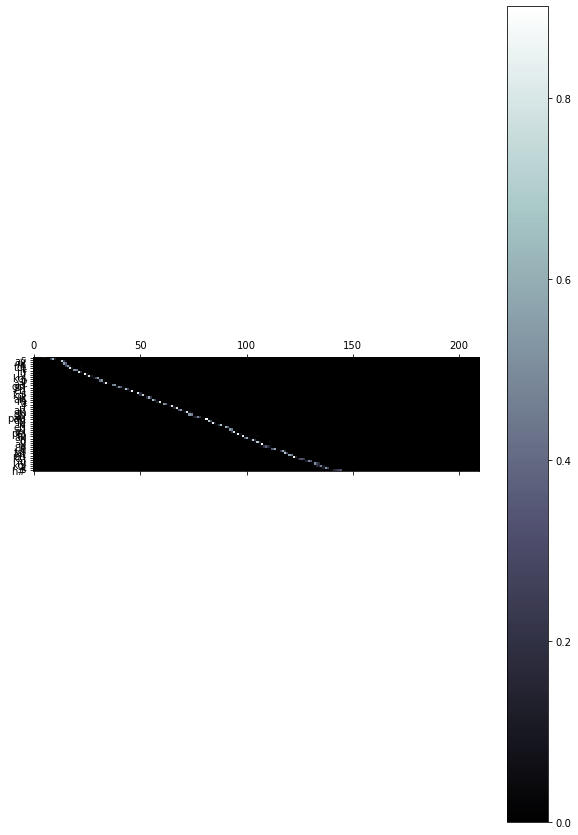

Predict:
b iy hv ay n dcl d hv ih m pau hh ix z epi m ey tcl t s tcl t er dcl w ax th aw tcl w ey kcl k ix ng h#
Ground-truth:
h# b iy hv ay n dcl d hh ih m pau hh ix z epi m ey tcl t s tcl t er dcl w ax th aw q w ey kcl k ix ng h#



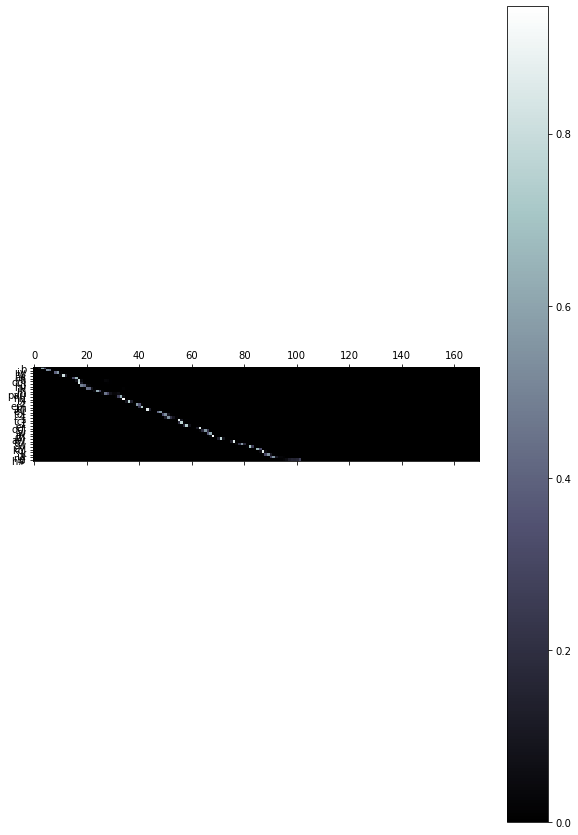

Predict:
q ey hh y ux dcl jh pcl p aw axr q aw dx ih dcl jh r eh l iy q ix kcl k er s h#
Ground-truth:
h# q ey hh y ux dcl jh pcl p aw er q aw dx ix dcl jh r eh l iy q ix kcl k er s h#



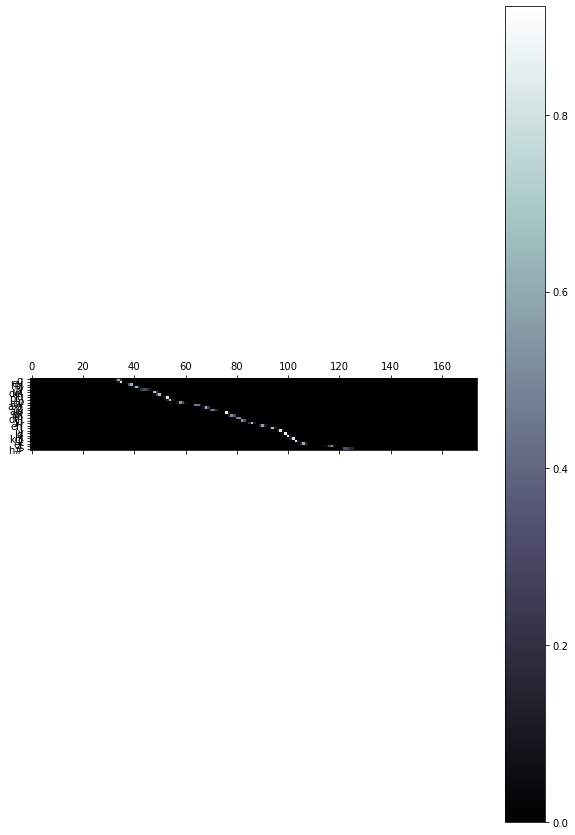

Predict:
b iy kcl k eh r f el n aa tcl t ix pcl p l aw ow v dh ax f l aw axr bcl b eh dcl z h#
Ground-truth:
h# b iy kcl k eh r f uh n aa tcl t ix pcl p l aw ow v dh ax f l aw axr bcl b eh dcl z h#



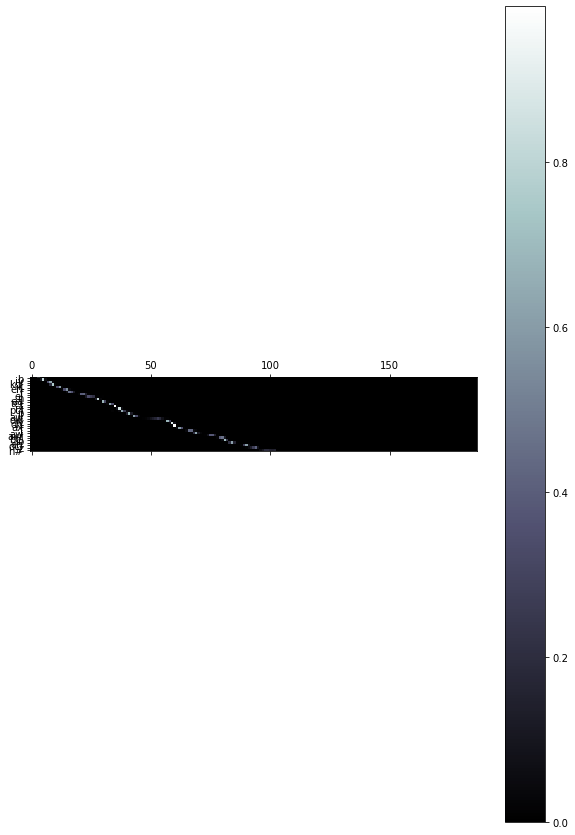

Predict:
hh iy tcl t s bcl b ae dcl f axr f ao s bcl b ay tcl t h#
Ground-truth:
h# hh iy tcl t s bcl b ae dcl f axr f r ao s bcl b ay tcl t h#



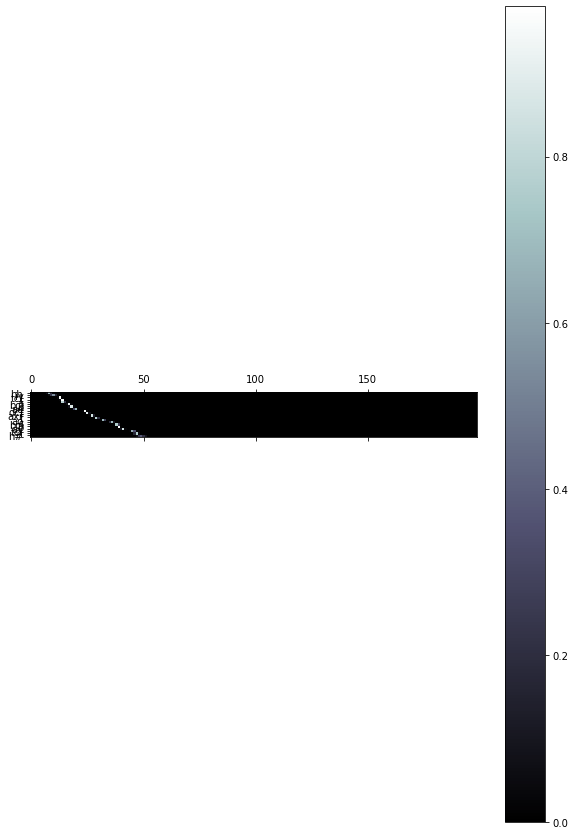

Predict:
s pcl p r ih ng s tcl t r iy tcl q ix s tcl t r ey dx ih hv eh dcl d h#
Ground-truth:
h# s pcl p r ih ng s tcl t r iy tcl q ih s tcl t r ey dx ih hv eh dcl d h#



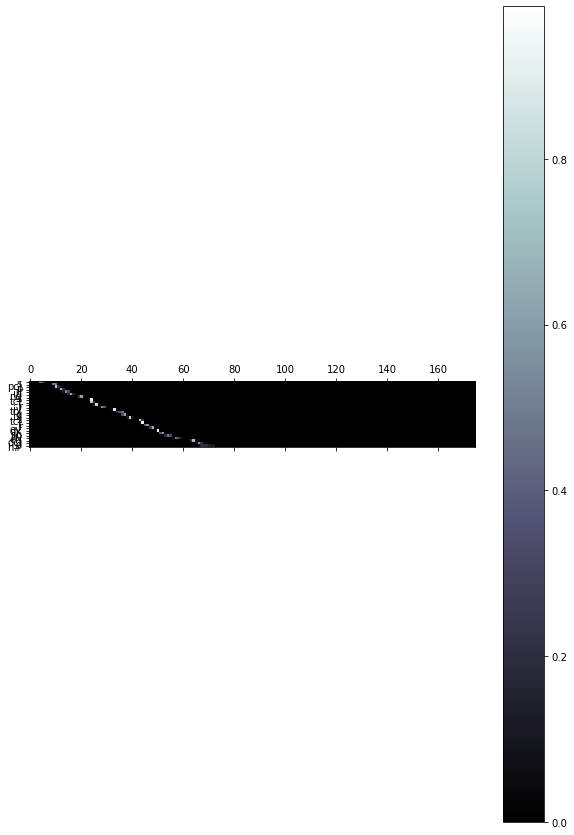

Predict:
n ux s eh l f tcl t ix s iy v ix ng r ae gcl z er hv er ix dcl l iy tcl t ao s tcl t aa n dh ax tcl t ux n ey kcl k ix dcl b ow n tcl t h#
Ground-truth:
h# n ux s eh l f tcl t ix s iy v ix ng r ae gcl z er hv er ix dcl l iy tcl t ao s tcl t ao n dh ax tcl t ux n ey kcl k ix dcl b ow n tcl t h#



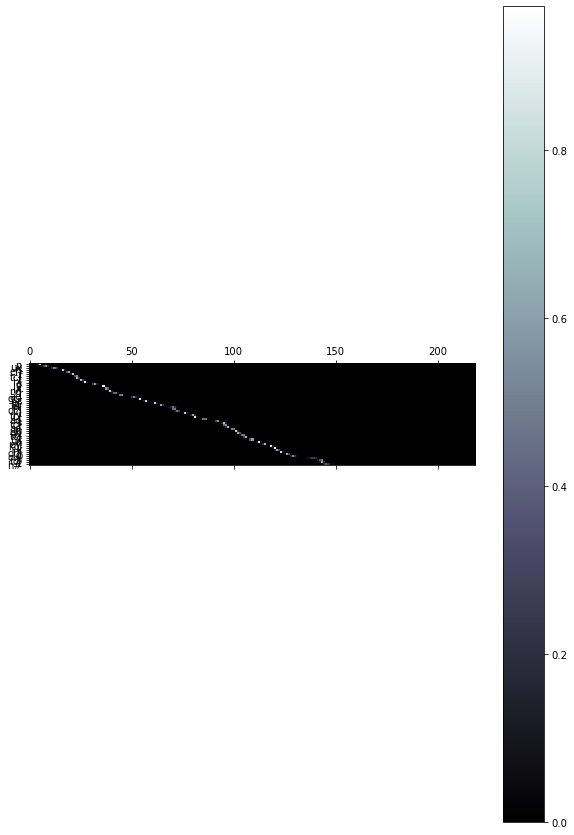

Predict:
t aa m ix s th ih ng kcl s pau q ey l aa r dcl jh axr kcl k l ae m pcl p s ao l v z dh ax pcl p r aa bcl b l ax m h#
Ground-truth:
h# t aa m ix s th ih ng kcl s pau q ey l aa r dcl jh axr kcl k l ae m pcl p s ao l v z dh ax pcl p r aa bcl b l ax m h#



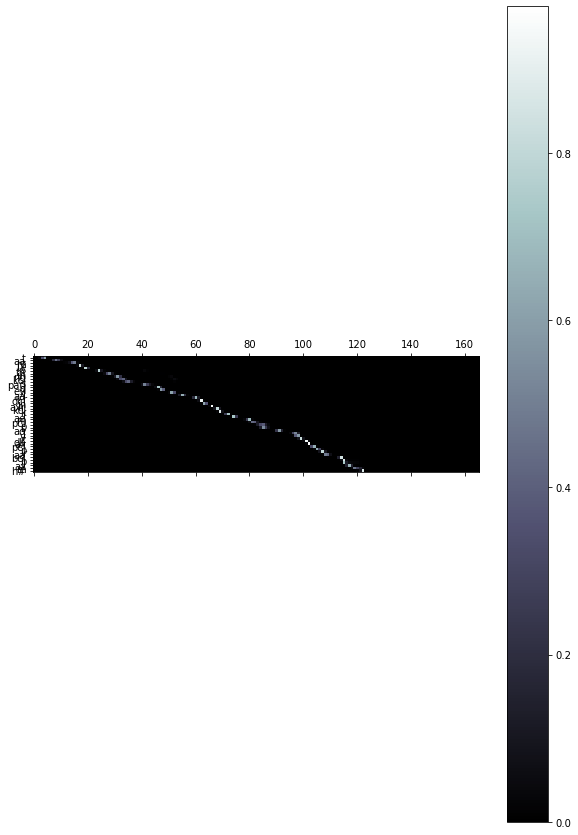

Predict:
dh ah z ae n tcl s er z el bcl b iy s tcl t r ey tcl f ao r w er dcl d ix f y ux th ih ng kcl dh ax m tcl t r ix kcl k eh r f el iy f er s tcl t h#
Ground-truth:
h# dh ah z ae n tcl s er z el bcl b ix s tcl t r ey q f ao r w axr dcl d ix f y ux epi th ih ng kcl dh ax m epi th r ux kcl k eh r f ax l ix f er s tcl t h#



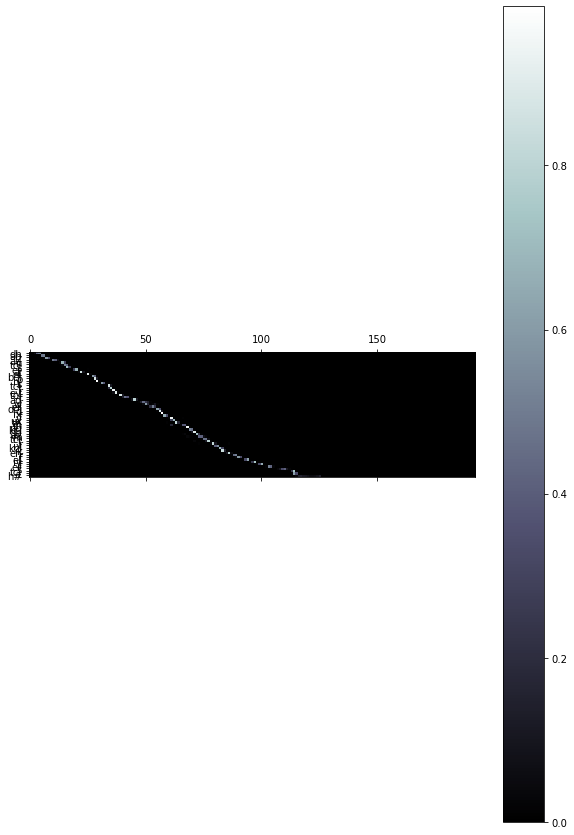

Predict:
s ax s ah m bcl b ah dx iy eh l s epi n ux w ah tcl w ix dcl hv ae pcl p ix n tcl t ux hv axr f aa dh axr z epi m ah n iy ix f sh iy dcl d ay dcl d h#
Ground-truth:
h# s ax s ah m bcl b ah dx iy eh l s epi n uw w ah tcl w ix dcl hv ae pcl p ix n tcl t uh hv axr f aa dh er z epi m ah n iy ix f sh iy dcl d ay dcl d h#



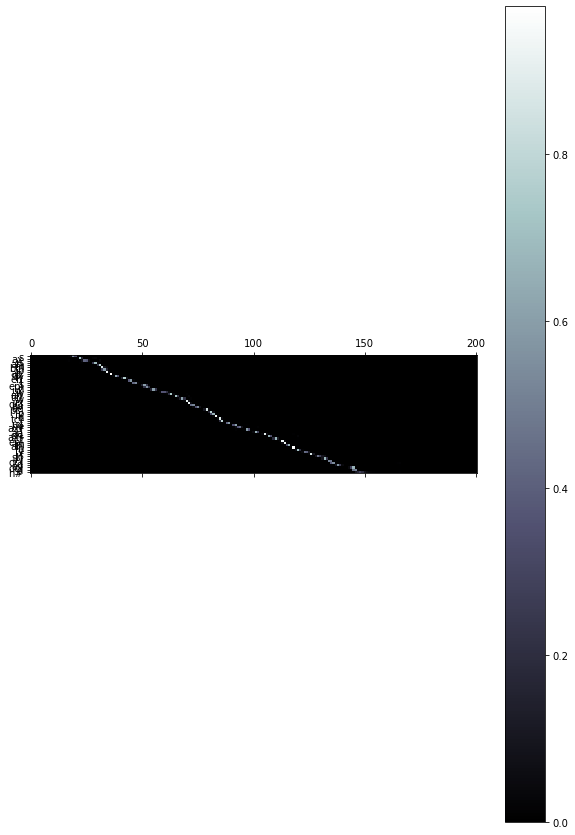

Predict:
m iy n w ay l pau th r iy gcl g r ey tcl t er ax bcl b el f ao r s ix z w er kcl k w ae gcl g y ax l ey dx iy ng ix n kcl k r ix s epi el ay z ix ng h#
Ground-truth:
h# m iy n w ay l pau th r iy gcl g r ey tcl t er ax bcl b el f ao r s ix z w er kcl k ow ae gcl g y ax l ey dx ix ng ix n kcl k r ih s tcl el ay z ix ng h#



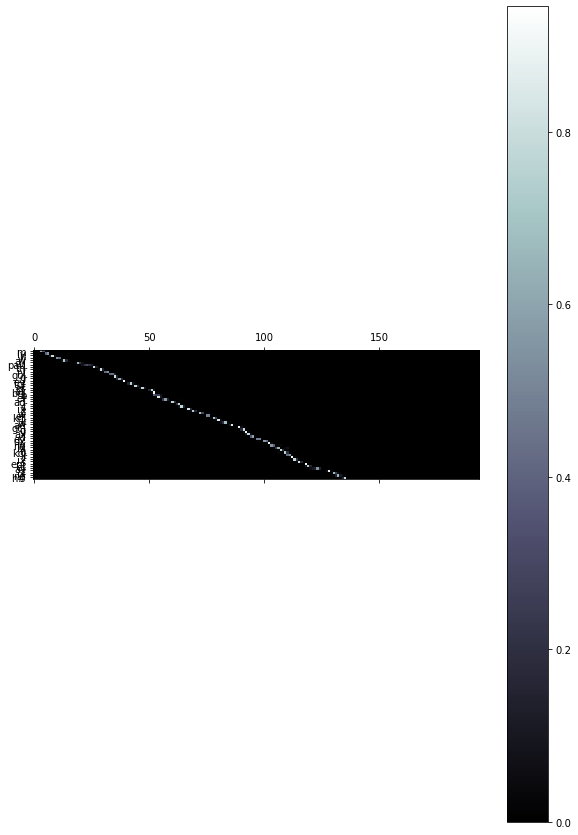

Predict:
s ah m hv eh v w aa kcl f r ux pcl p ey n ix n s aa r ix dx ix bcl b r ih ng y ux dh eh r m eh s ix dcl jh ix v hh ow pcl p h#
Ground-truth:
h# s ah m hv eh v w aa kcl th r ux pcl p ey n ix n tcl s aa r ix dx ix bcl b r ih ng y ux dh eh r m eh epi s ix dcl jh ix v epi hh ow pcl p h#



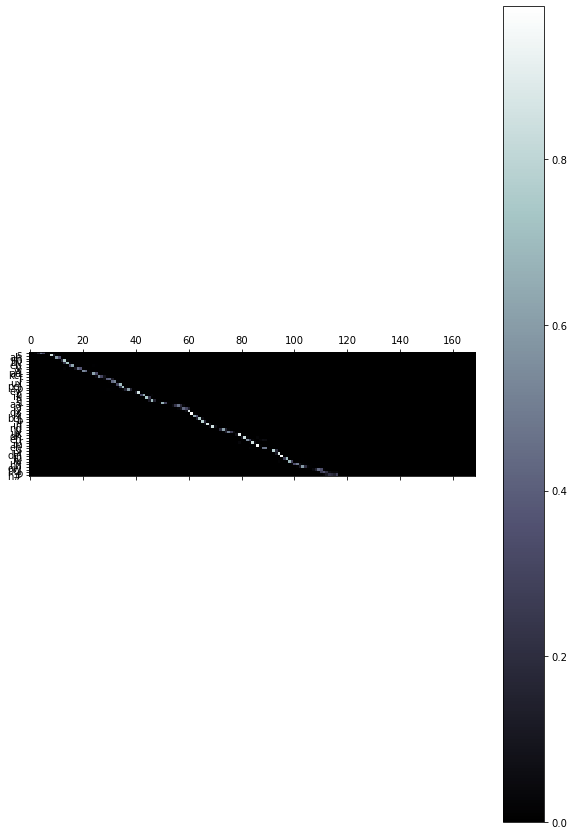

Predict:
m ay dcl d ih l m ao r nx ix ng bcl b ix gcl g ih z w ax th hh aa tcl k ao f iy h#
Ground-truth:
h# m aa ay dcl d ih l m ao r nx ix ng bcl b ix gcl g ih z w ax th hh aa q kcl k ao f iy h#



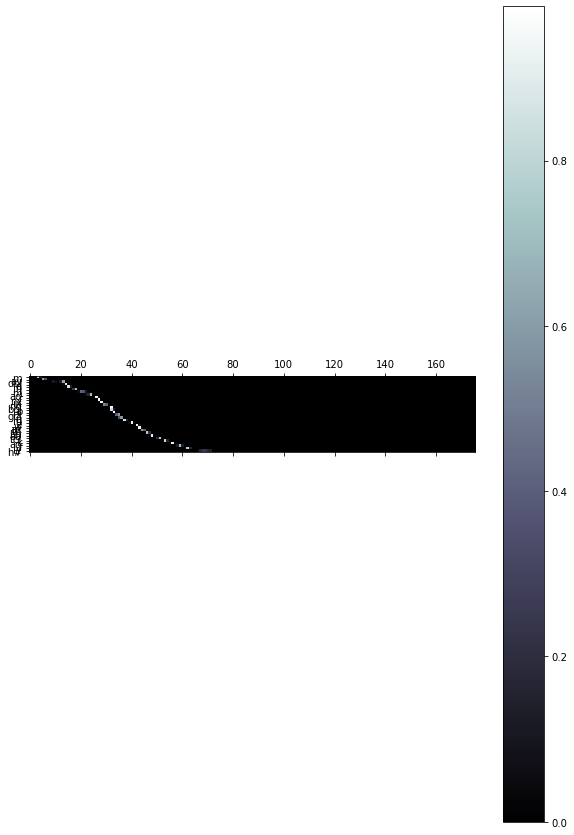

Predict:
w iy ix pcl p l ay q ao dx ix tcl t ao r iy m aa dx ax l ix ng tcl t ux kcl k em pcl p y ux dx axr s pcl p iy tcl ch epi r eh kcl k ix gcl n ih sh en h#
Ground-truth:
h# w iy ix pcl p l ay q ao dx ih tcl t ao r iy m aa dx ax l ix ng tcl t ux kcl k em pcl p y ux dx axr s pcl p iy tcl ch epi r eh kcl k ix gcl n ih sh en h#



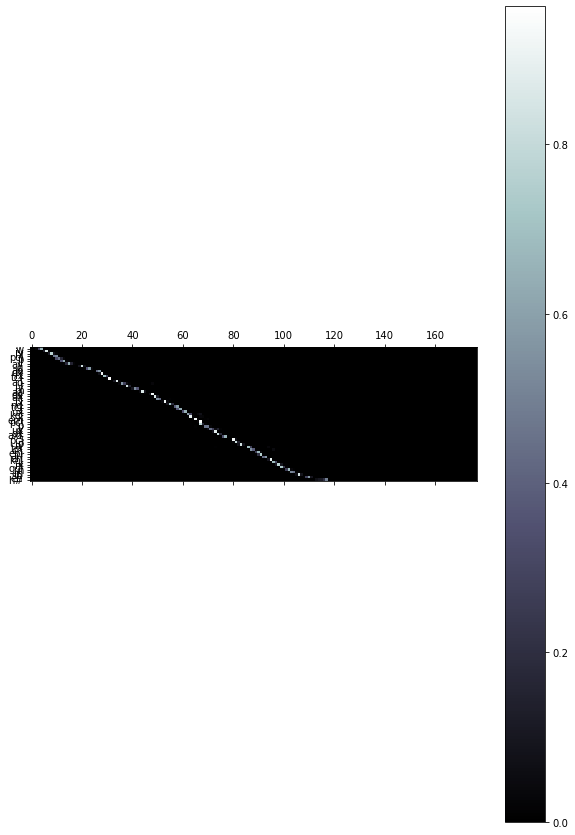

Predict:
sh eh l sh aa kcl k aa z bcl b ay sh r ae pcl n ax l ix s ah m tcl t ah n z kcl k y er dcl th r ux gcl g r ux pcl p th eh er pcl p iy h#
Ground-truth:
h# sh eh l sh aa kcl k ao z bcl b ay sh r ae pcl q n ah l ix s ah m tcl t ay m z kcl k y er dcl th r ux gcl g r ux pcl p th eh er pcl p iy h#



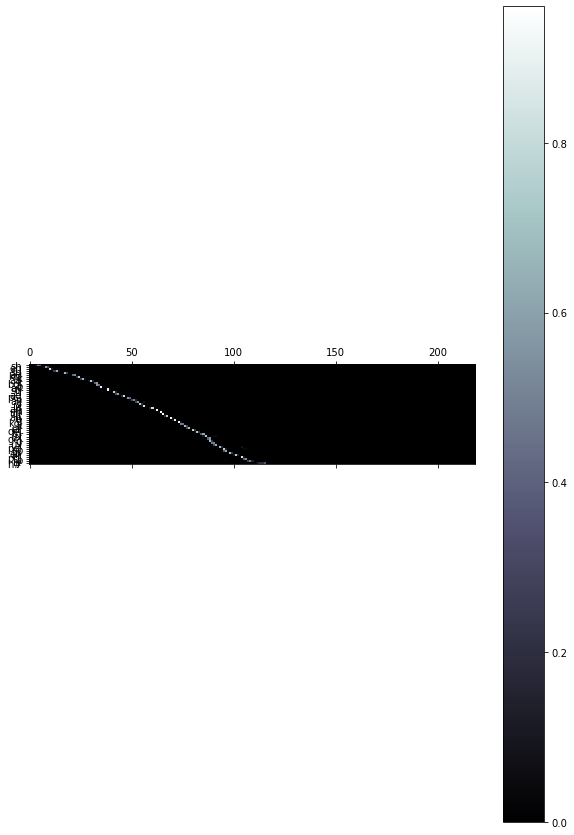

Predict:
dh ey eh dcl k ah m n aa tcl t uw ix dcl m ay axr bcl b ax tcl t uw ax bcl b z er v h#
Ground-truth:
h# dh ey eh dcl k ah m n aa tcl t ux ix dcl m ay axr bcl b ax tcl t ux ix bcl b z er v h#



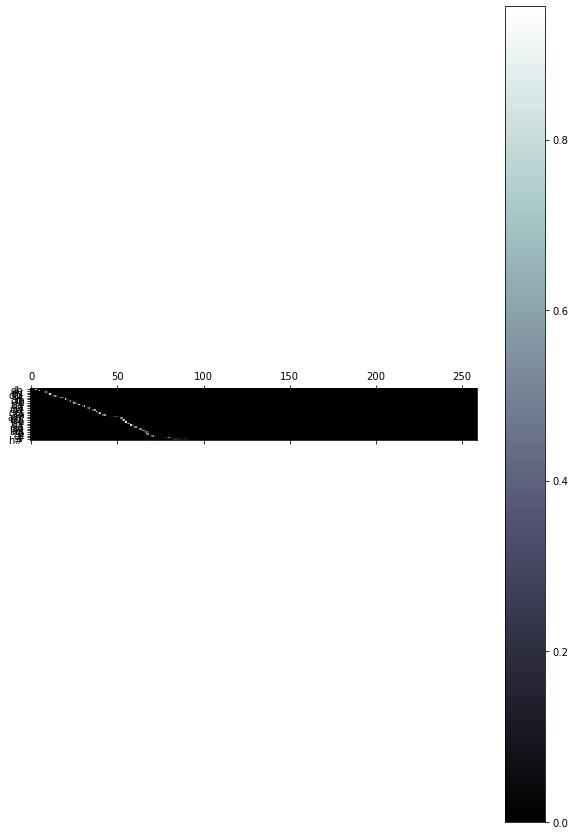

Predict:
dh ix bcl b ih gcl d ao gcl pau l ow f tcl t ax-h tcl ch ux aa n dh iy ow l dcl d r ae gcl d ao l h#
Ground-truth:
h# dh ix bcl b ih gcl d ao gcl pau l ah v dcl t ix tcl ch uw ao n dh iy ow l dcl r ae gcl d aa l h#



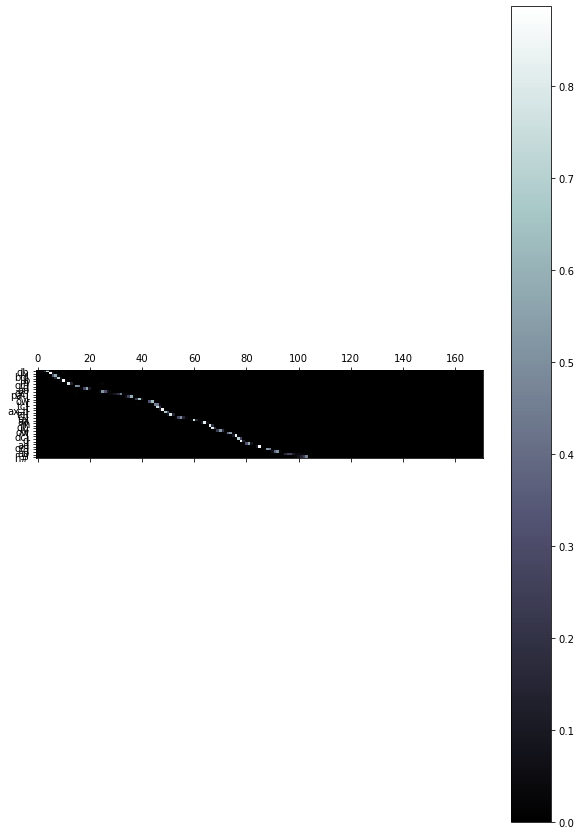

Predict:
m ix s kcl k iy dx ow z q ih gcl g z ih s tcl t ih n ax w ao r m hv y ux m ih dcl d kcl k l ay m ax tcl t s h#
Ground-truth:
h# m ix s kcl k iy dx ow z q ih gcl g z ih s tcl t ih n ax w ao r m hh y uw m ih dcl d kcl k l ay m ax tcl t s h#



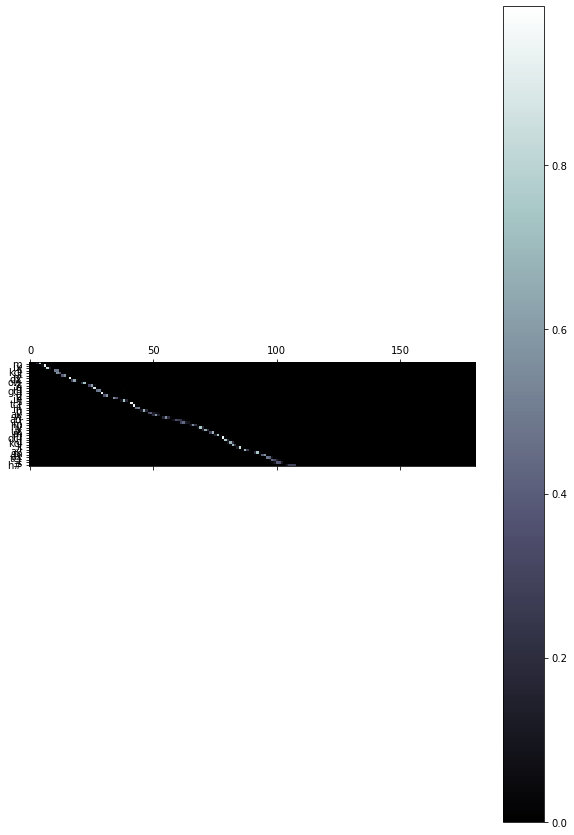

Predict:
dh ih gcl g ah v axr m ix tcl s ao q ao th axr ix z ey sh en q ax v hh ix s ix dx ix s ix n sh ix pcl p h#
Ground-truth:
h# dh ih gcl g ah v axr m ih tcl s ao q ao th axr ix z ey sh en q ax v hh ix s ix dx ix s ax n sh ix pcl p h#



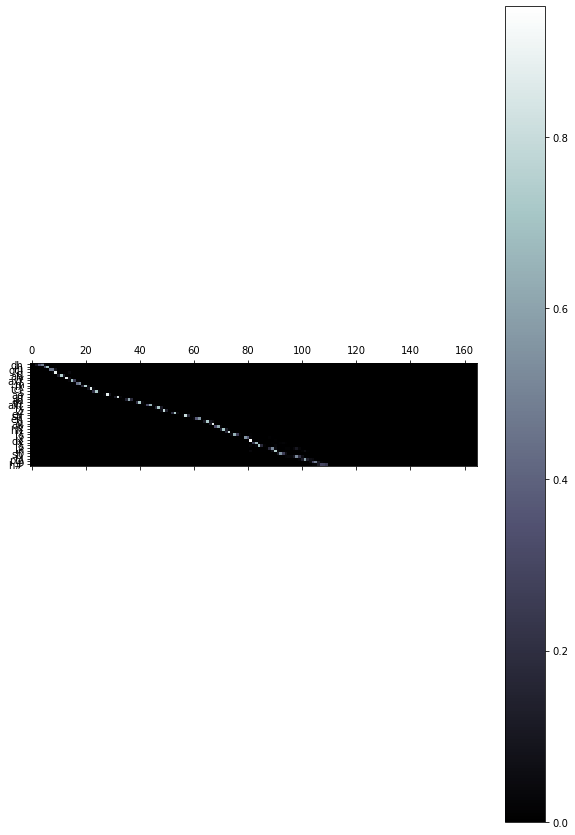

Predict:
dh ix s ih ng er z f ih ng gcl g er hh ae dx ix s pcl p l ih n tcl t axr h#
Ground-truth:
h# dh ix s ih ng er z f ih ng gcl g er hh ae dx ix s pcl p l ih n tcl t er h#



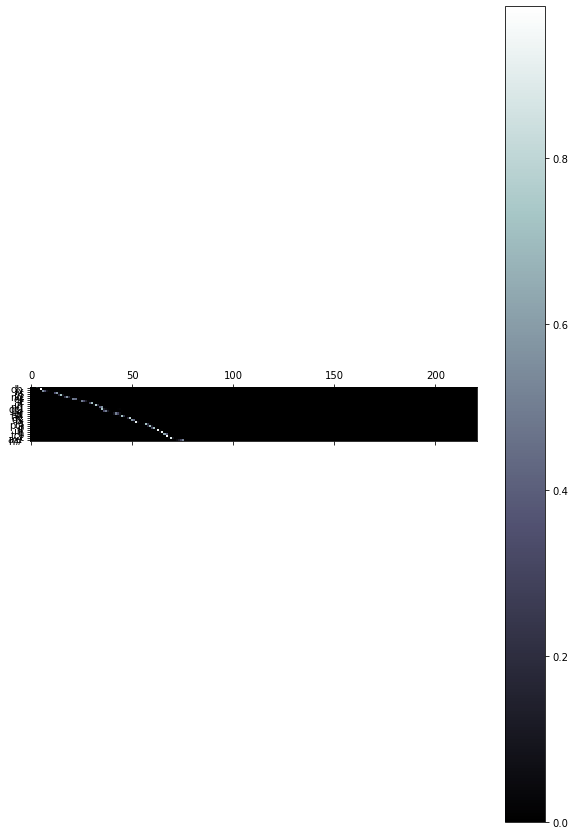

Predict:
m ay dcl d ih z ay axr z ax s eh m pcl p el pau g ix m iy w ah n ix n f ao r m ix tcl t ix v pcl p eh r gcl r ae f ao n dh ax s ah bcl jh ix kcl h#
Ground-truth:
h# m ay dcl d ih z ay axr z ah s ih m pcl p el pau g ix m iy w ah n ih n f ao r m ax tcl t ix v pcl p eh axr gcl r ae f ao n dh ax s ah bcl jh ix kcl h#



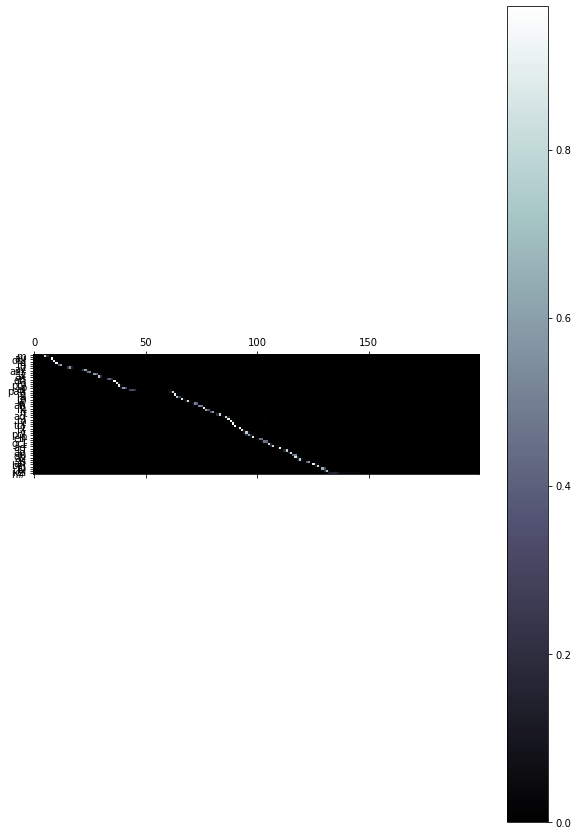

Predict:
dh ax bcl b l ux dcl jh ey f l uw ow v axr dh ax hv ay bcl b ih l q ix ng h#
Ground-truth:
h# dh ax bcl b l ux dcl jh ey f l uw ow v axr dh ax hv ay bcl b ih l q ix ng h#



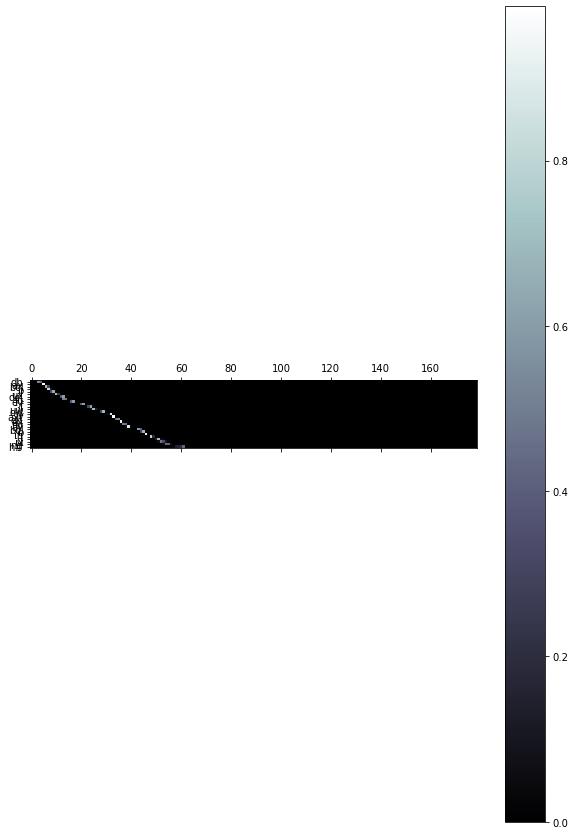

Predict:
r ix s ih s tcl t en s th ax m aa m ax dx er s h#
Ground-truth:
h# r ax-h s ih s tcl t en s th axr m aa m ax dx er s h#



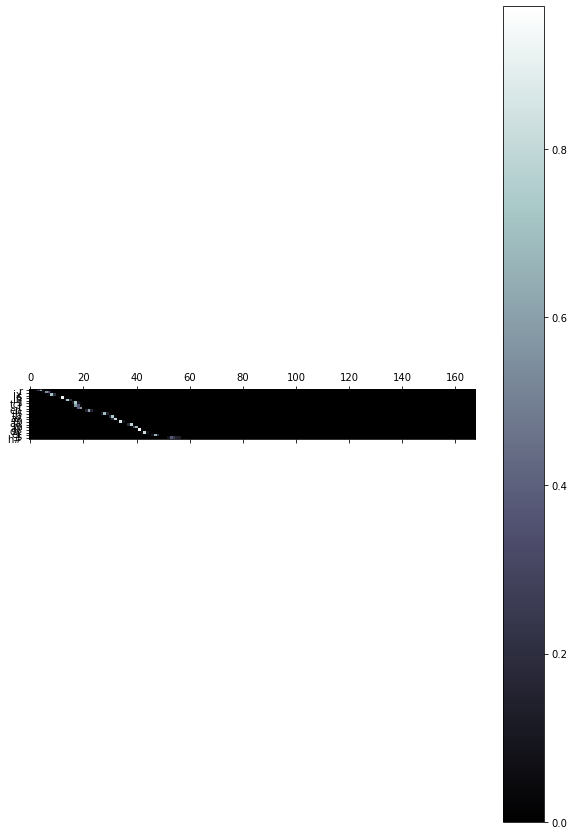

Predict:
q ae l r ix s iy dcl d ix dcl jh oy nx ix pcl p oy n q m ax n tcl ix n dh ix bcl b aa l ax dcl jh iy q ae n dh iy ix n dcl jh en er ix ng dcl d ix pcl p aa r tcl m en tcl t s h#
Ground-truth:
h# q ae l r ix s iy dcl d ix dcl jh oy nx ix pcl p oy n tcl m ax n tcl ix n dh ix bcl b aa ao l ax dcl jh iy q ae n dh iy ix n dcl jh en er ix ng dcl d ix pcl p aa r tcl m en tcl t s h#



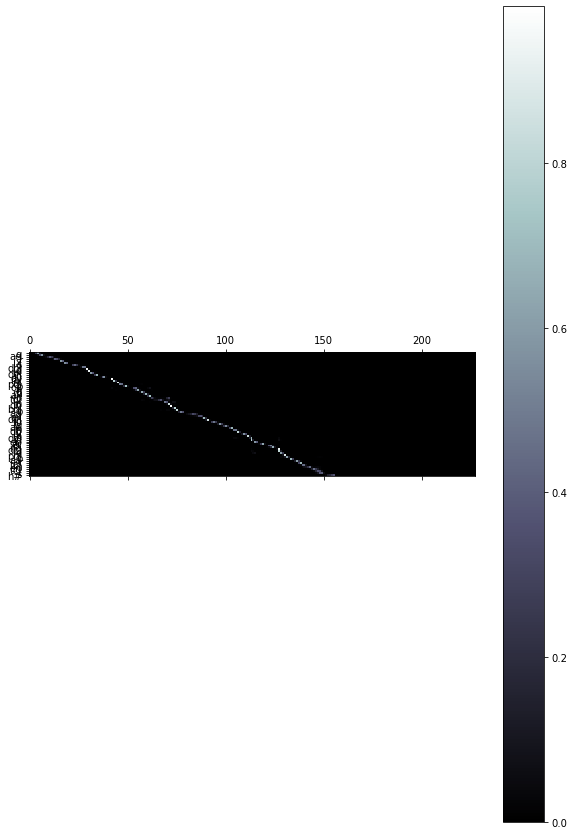

Predict:
hh aw dx ih ng aw q l ay kcl dh ih s epi w ow ng gcl g ih dx ih m ih nx iy th ih ng ix gcl s eh tcl m ao r tcl t r ah bcl b el ao r bcl b uh l ix tcl h#
Ground-truth:
h# hh aa dx ih ng aw q l ay kcl dh ih s epi w ow ng gcl g ih dx ih m ih nx ih th ih ng ix kcl s eh pcl m ao r tcl t r ah bcl b el ao r bcl b uh l ih tcl h#



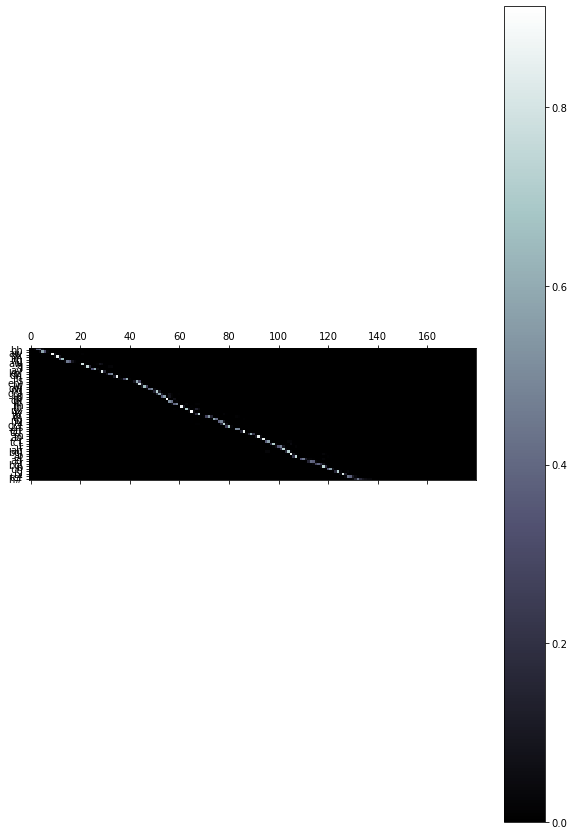

Predict:
hh ih z pcl p ax-h tcl t r ey ax v q ah v ax n q eh dcl jh iy hv eh dcl d ix n dh ix kcl k l aw dcl z pau q aa r dcl d ix s tcl t pau ih z v er tcl ch ax l iy f l ao l ix s h#
Ground-truth:
h# hh ih z pcl p ax-h tcl t r ey ix l q ah v ax n q eh dcl jh iy hv eh dcl d ix n dh ix kcl k l aw dcl z q aa r tcl t ix s tcl t pau ix z v er tcl ch el iy f l ao l ax s h#



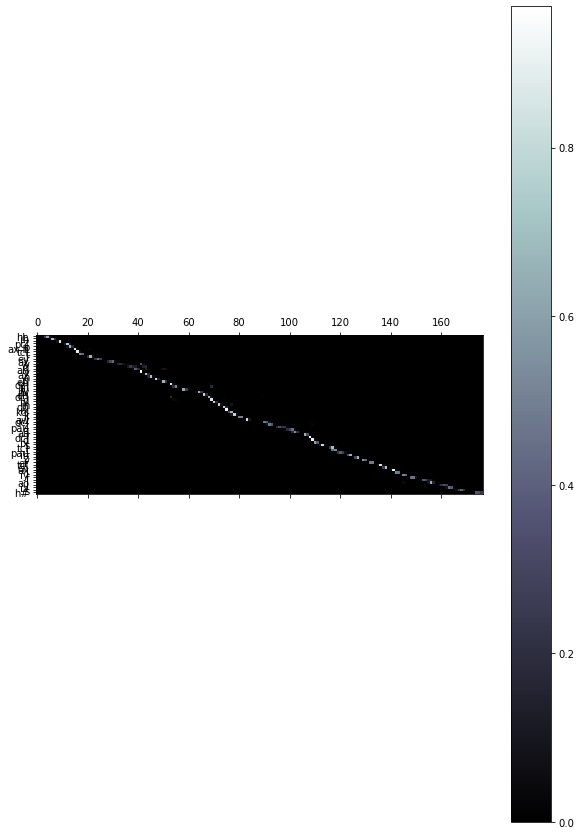

Predict:
m ay dcl d ih z ay er z ax s ih m pcl p el pau g ih v epi m iy w ah n ix n f ao r m axr dx ix v pcl p eh axr gcl r ae f ao n dh ax s ah bcl jh eh kcl t h#
Ground-truth:
h# m ay dcl d ih z ay axr r z ax s ih m pcl p el pau g ih v epi m iy w ah n ih n epi f ao r m ix dx ix v pcl p ae axr gcl g r ae f ao n ix s ah bcl jh eh kcl t h#



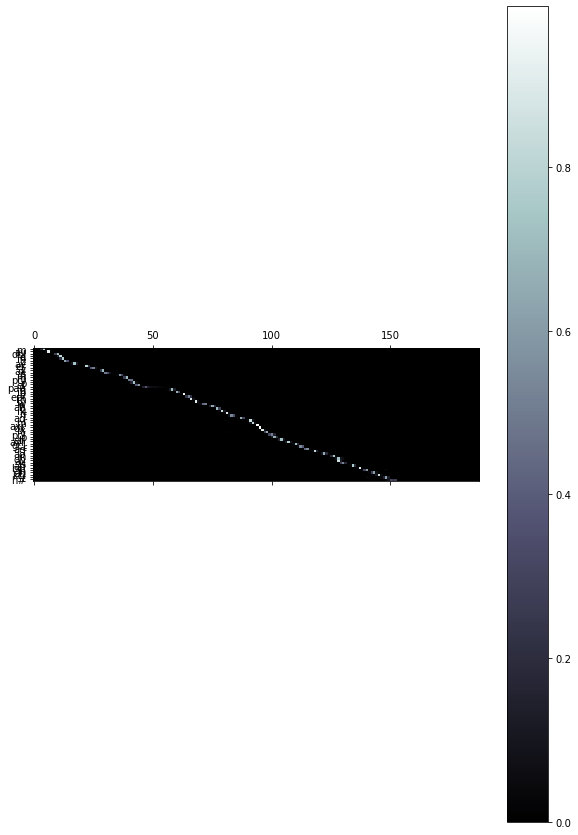

Predict:
p l iy s ih ng dcl jh eh s dh ix kcl k l ah bcl b th iy m h#
Ground-truth:
h# p l iy s ih ng dcl jh eh s dh ix kcl k l ah bcl b th iy m h#



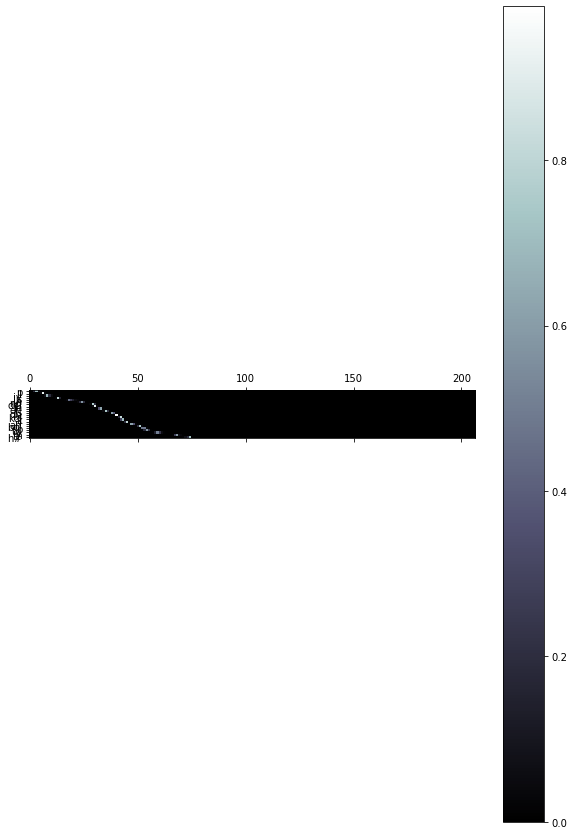

Predict:
ax r ow l ax v w aa axr l ey n ih axr dh ax w ao l h#
Ground-truth:
h# ax r ow l ax v w aa axr l ey n ih axr dh ax w ao l h#



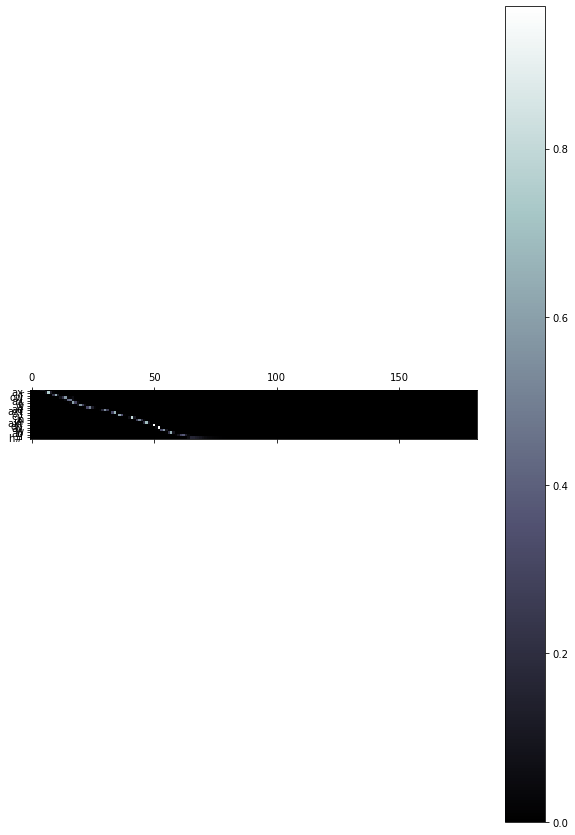

Predict:
k w ih n tcl t s iy dcl g ah m ih z dh ax m ey nx ih n gcl g r ih dx ih ix n q ix n w ey v s eh dx iy n l ow sh en tcl s h#
Ground-truth:
h# k w ih n tcl t s iy dcl g ah m ih z dh ax m ey nx ih n gcl g r ih dx ix ih n q ix n w ey v s eh dx iy n l ow sh en tcl t s h#



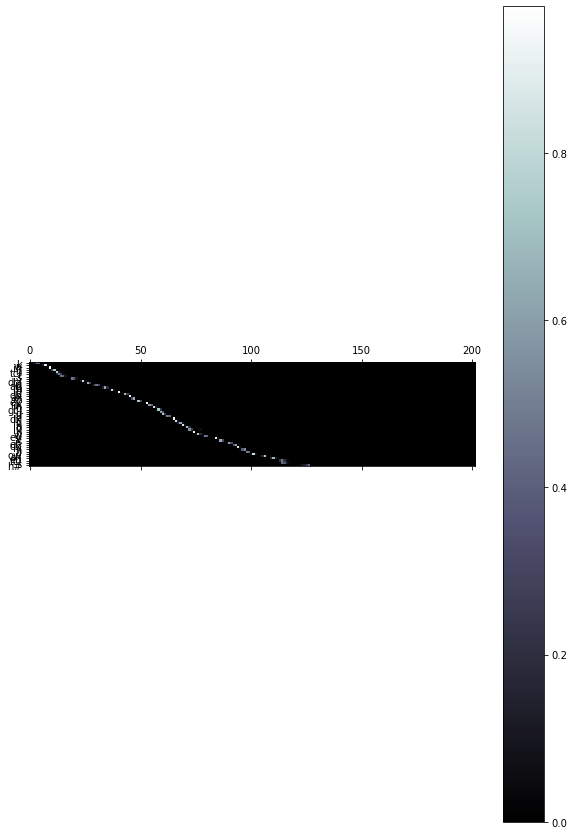

Predict:
w ay dcl d ow n tcl dh ey tcl t eh l m iy dh ih m s eh l v z q ih f ih tcl b aa dh ax z dh eh ax m h#
Ground-truth:
h# w ay dcl d ow n tcl dh ey tcl t eh l m iy th eh m s eh l v z q ix f ih tcl b aa dh ax z dh eh ax m h#



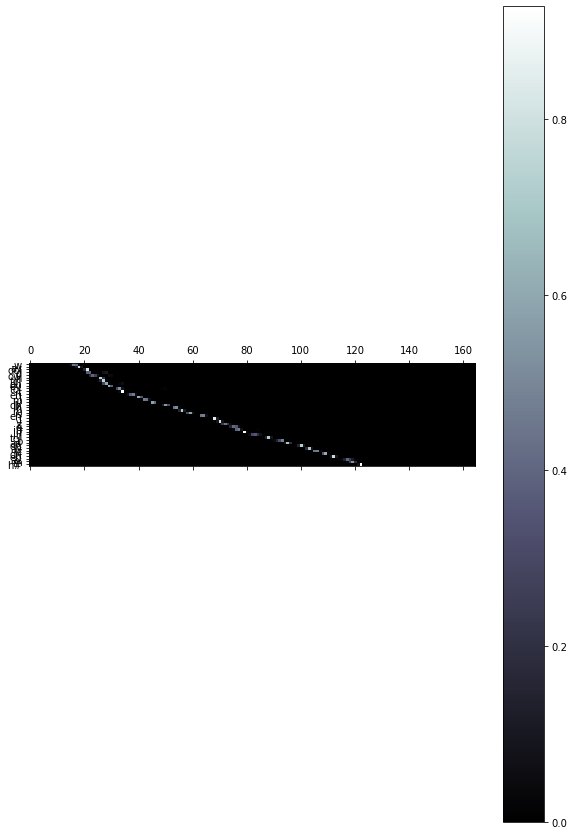

Predict:
k l ih er pcl p axr n ah n s iy ey sh ix n q ix z ax pcl p r iy sh iy ey dx ix dcl h#
Ground-truth:
h# k l ih axr pcl p axr n ah n s iy ey sh ix n q ix z ax pcl p r iy sh iy ey dx ix dcl h#



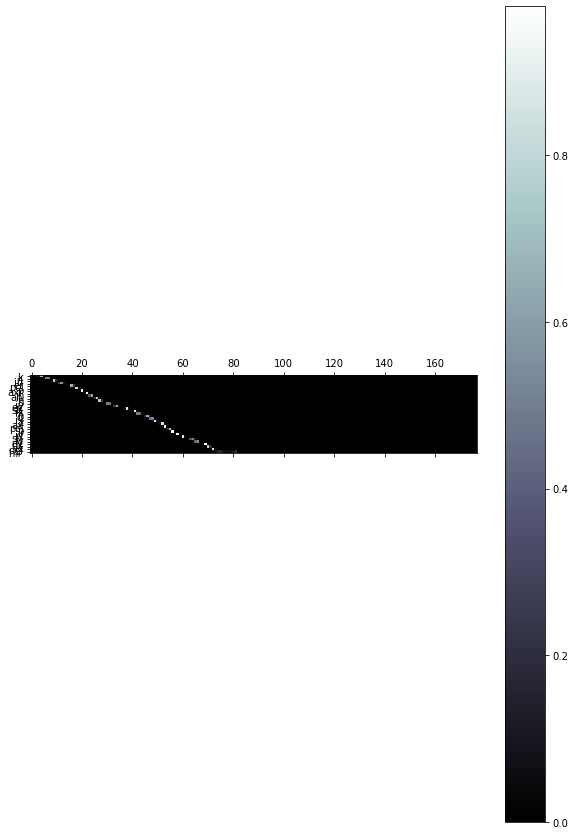

Predict:
w eh s tcl ch eh s er q ih z ey kcl k aw n iy q ix n ux y ao r kcl k h#
Ground-truth:
h# w eh s tcl ch eh s axr q ih z ey kcl k aw n iy q ix n ux y ao r kcl k h#



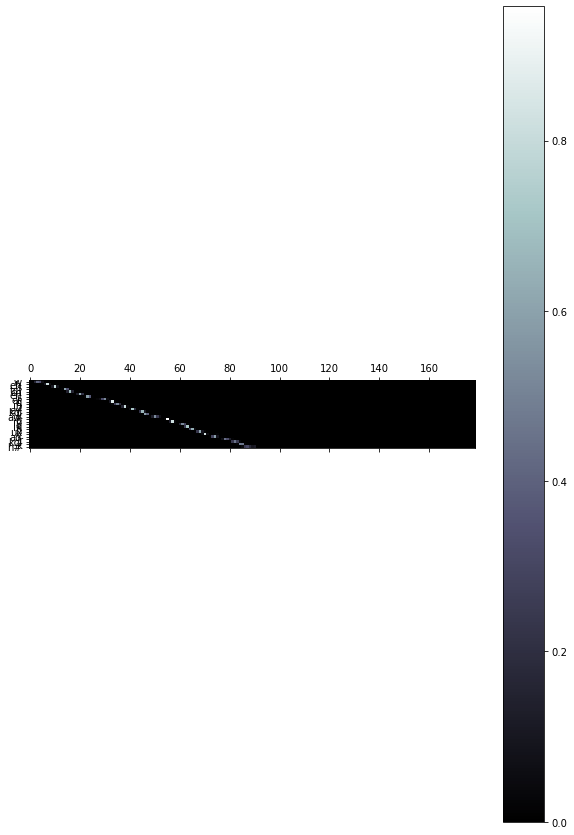

Predict:
sh iy s m ay ah l dcl d pau ix n tcl t iy th gcl g l iy m dcl d pau q eh n axr bcl b y ux dx ix f l iy m aa dx el dcl d q aa l ax v f ey s h#
Ground-truth:
h# sh iy s m ay eh l dcl d q ix n tcl t iy th gcl g l iy m dcl d pau ix n axr bcl b y ux dx uh f l iy m aa dx el dcl d q aa l ax v f ey s h#



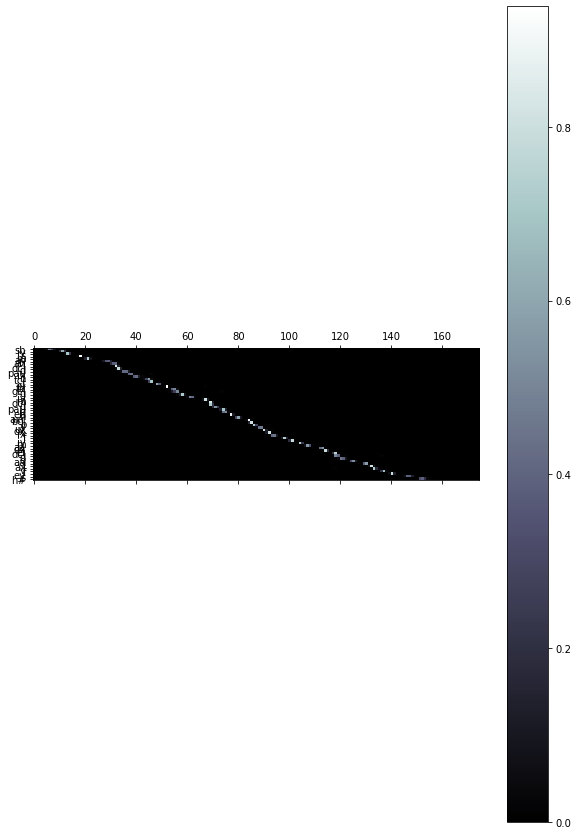

Predict:
dh ey ao l ay kcl k l ao ng hh aa tcl t sh aw axr s h#
Ground-truth:
h# dh ey ao l ay kcl k l ao ng hv aa tcl t sh aw axr s h#



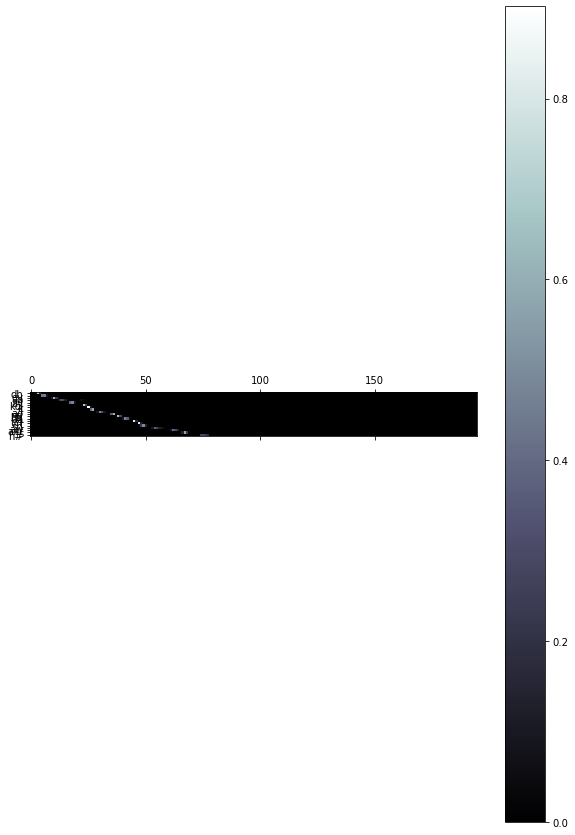

Predict:
d aa kcl k tcl t axr z pcl p axr s kcl k r ay bcl d r ah gcl g z tcl t ux f r iy l iy h#
Ground-truth:
h# d aa kcl k tcl t axr z pcl p axr s kcl k r ay bcl d r ah gcl g z tcl t ux f r iy l iy h#



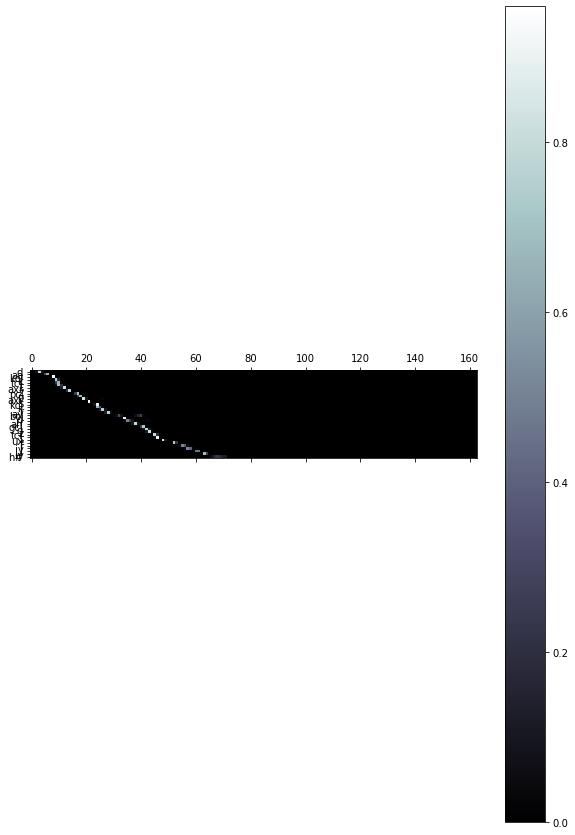

Predict:
r aa kcl k ax n r ow l m y ux z ix kcl k hh eh z ix gcl g r ey tcl r ih dh ax m h#
Ground-truth:
h# r aa kcl k ix n r ow l m y ux z ix kcl hh eh z ix gcl g r ey q r ih dh ax m h#



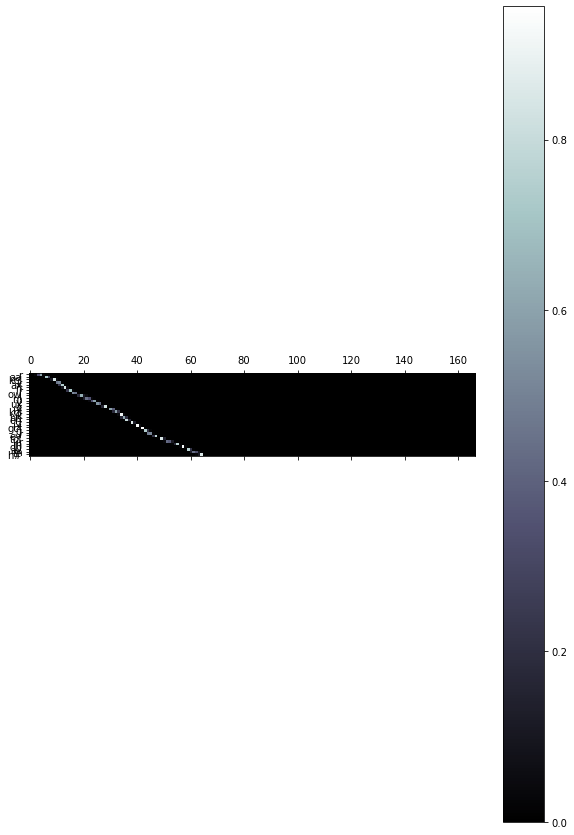

Predict:
k ao f iy ih z gcl g r ow nx ow n s tcl t iy pcl jh ah ng gcl g el l ay kcl k s l ow pcl p s ih n tcl t eh m pcl p r ih tcl z ow n z h#
Ground-truth:
h# k ao f iy ih z gcl g r ow nx ow n s tcl t iy pcl jh ah ng gcl g el l ay kcl k s l ow pcl p s ih n tcl t eh m pcl p r ih tcl z ow n z h#



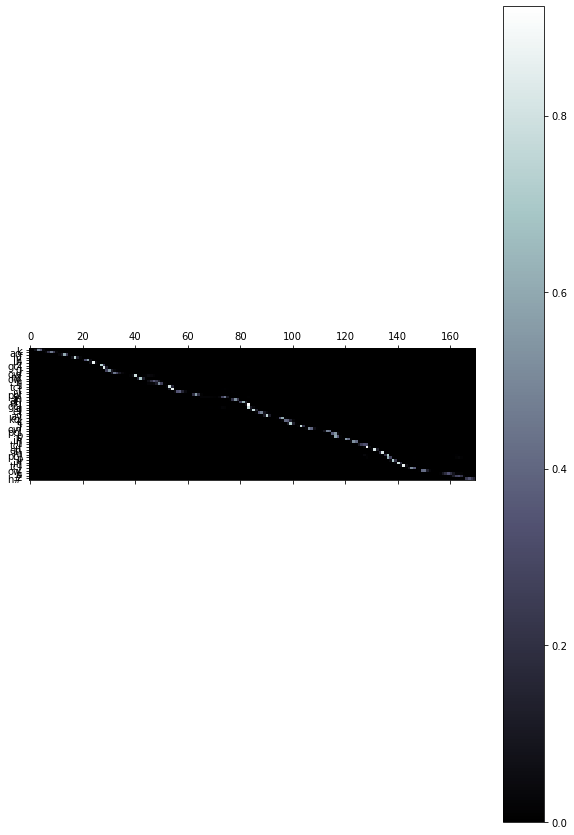

In [18]:
# Inference
with torch.no_grad():
    for (x, xlens, y) in train_loader:
        predictions, attentions = model(x.cuda(), xlens)
        predictions, attentions = predictions[0], attentions[0]
        predictions = tokenizer.decode(predictions)
        attentions = attentions[:len(predictions.split())].cpu().numpy()   # (target_length, source_length)
        ground_truth = tokenizer.decode(y[0])
        print ("Predict:")
        print (predictions)
        print ("Ground-truth:")
        print (ground_truth)
        print ()
        showAttention(predictions, attentions)

In [19]:
epoch = 0
with open('config/default/timing.csv', 'w') as filehandle:
    for (train_epoch_duration, eval_epoch_duration, RMSE) in zip(train_epoch_durations, eval_epoch_durations, RMS):
        msg = '%d, %s, %s, %s \n' % (epoch, train_epoch_duration, eval_epoch_duration, RMSE)
        #print(msg)
        epoch = epoch +1 
        filehandle.write(msg)